In [1]:
import glob
import os
import numpy as np
import pandas as pd
import open3d as o3d
from matplotlib import pyplot as plt
from shapely.geometry import MultiLineString, Point, LineString
from shapely.ops import unary_union, polygonize
import scipy
from scipy.io import savemat
from scipy.spatial import Delaunay, ConvexHull, distance_matrix
from scipy.spatial.transform import Rotation as RR
from collections import Counter
import itertools
import time
import cv2
import copy
import utils
import skimage
import enum
import h5py
import cycpd

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [2]:
SSM_DIR = r"./data/cpdAlignedData/eigValVec/"
CPD_ALIGNED_DIR = r"./data/cpdAlignedData/"
NAME_IDX_MAP_CSV = r"./dataWithPhoto/nameIndexMapping.csv"
EDGE_MASK_PATH = r"./dataWithPhoto/normal_mask/"
RGB_EDGE_MASK_PATH = r"./dataWithPhoto/normal_mask/RGB/"
NUM_PC = 2
PG_NPY = os.path.join("res-2D-3D", "Y_pg.npy")
MASK_NPY = os.path.join("res-2D-3D", "X_mask.npy")
PARAM_DIR = r"./data/params/"
UPPER_INDICES = [11,12,13,14,15,16,17,21,22,23,24,25,26,27] #不考虑智齿18,28
LOWER_INDICES = [31,32,33,34,35,36,37,41,42,43,44,45,46,47] #不考虑智齿38,48

In [3]:
TagID = 18 # 18 # 90 # 42 # 10 # 24 # 54 # 47 # 63 #              
name_idx_df = pd.read_csv(NAME_IDX_MAP_CSV)
photo_types = ["upperPhoto","lowerPhoto","leftPhoto","rightPhoto","frontalPhoto"]

In [4]:
def getEdgeMask(edge_mask_path, name_idx_df, TagID, photo_types, resized_width=800):
    photoFiles = name_idx_df.loc[name_idx_df["index"]==TagID, photo_types].values[0]
    edgeMaskFiles = [os.path.join(edge_mask_path, os.path.splitext(os.path.basename(pf))[0]+".png") for pf in photoFiles]
    print(edgeMaskFiles)
    edgeMasks = []
    for edgeMaskFile in edgeMaskFiles:
        edgeMask = skimage.io.imread(edgeMaskFile, as_gray=True)
        rescale = resized_width / edgeMask.shape[1]
        edgeMask = skimage.transform.rescale(edgeMask, rescale, anti_aliasing=True)
        thre = 0.5
        edgeMask[edgeMask<thre] = 0.
        edgeMask[edgeMask>=thre] = 1.
        # edgeMask = skimage.morphology.binary_erosion(edgeMask, footprint=skimage.morphology.disk(2))
        edgeMasks.append(edgeMask)
    return edgeMasks

def getRgbEdgeMask(edge_mask_path, name_idx_df, TagID, photo_types, resized_width=800):
    photoFiles = name_idx_df.loc[name_idx_df["index"]==TagID, photo_types].values[0]
    edgeMaskFiles = [os.path.join(edge_mask_path, os.path.splitext(os.path.basename(pf))[0]+".png") for pf in photoFiles]
    print(edgeMaskFiles)
    edgeMasks = []
    for edgeMaskFile in edgeMaskFiles:
        edgeMask = skimage.io.imread(edgeMaskFile, as_gray=False)
        rescale = resized_width / edgeMask.shape[1]
        edgeMask = skimage.transform.rescale(edgeMask, rescale, anti_aliasing=True, channel_axis=2)
        thre = 0.9
        edgeMask[edgeMask<thre] = 0.
        edgeMask[edgeMask>=thre] = 1.
        # edgeMask = skimage.morphology.binary_erosion(edgeMask, footprint=skimage.morphology.disk(2))
        edgeMasks.append(edgeMask[...,:3])
    return edgeMasks

In [5]:
edgeMasks = getEdgeMask(EDGE_MASK_PATH, name_idx_df, TagID, photo_types, resized_width=800)
# edgeMasks = getRgbEdgeMask(RGB_EDGE_MASK_PATH, name_idx_df, TagID, photo_types, resized_width=800)

['./dataWithPhoto/normal_mask/陈希_218188_上牙列.png', './dataWithPhoto/normal_mask/陈希_218188_下牙列.png', './dataWithPhoto/normal_mask/陈希_218188_左侧咬合.png', './dataWithPhoto/normal_mask/陈希_218188_右侧咬合.png', './dataWithPhoto/normal_mask/陈希_218188_正位像.png']


(600, 800)
num of contour points in upperPhoto: 8326 
(600, 800)
num of contour points in lowerPhoto: 7525 
(600, 800)
num of contour points in leftPhoto: 6753 
(600, 800)
num of contour points in rightPhoto: 6478 
(600, 800)
num of contour points in frontalPhoto: 5969 


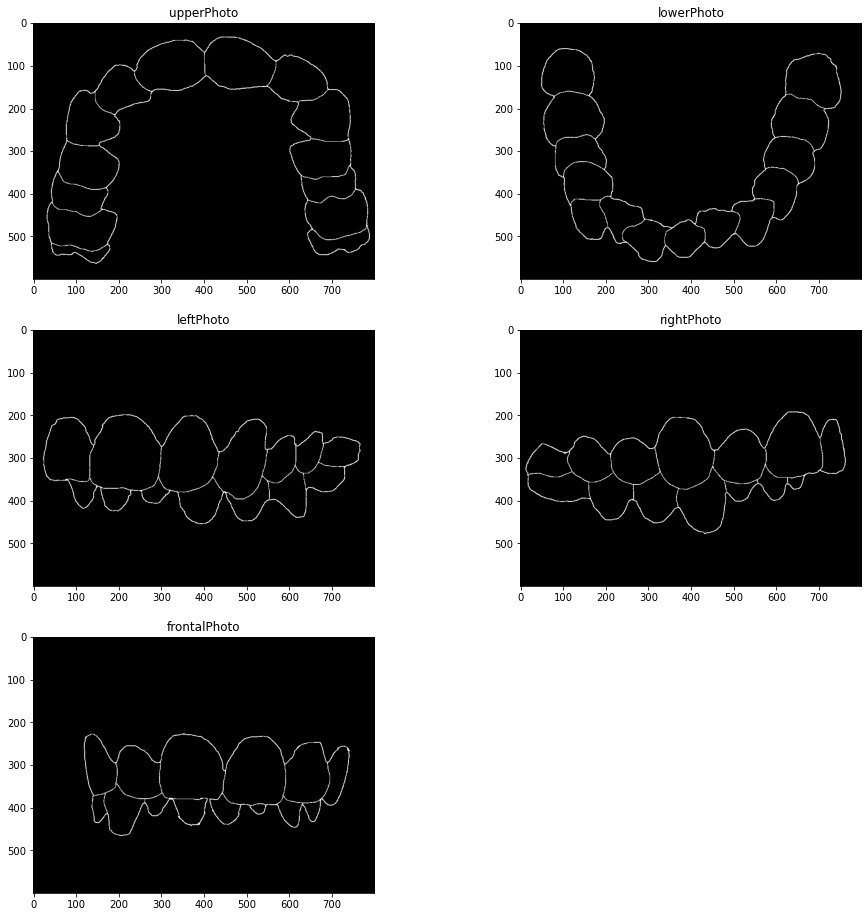

In [6]:
plt.figure(figsize=(16,16))
for i,ptype in enumerate(photo_types):
    plt.subplot(3,2,i+1)
    plt.imshow(edgeMasks[i], cmap='gray')
    plt.title(ptype)
    print(edgeMasks[i].shape)
    print("num of contour points in {}: {} ".format(ptype, np.sum(edgeMasks[i]>0)))

In [7]:
def GetPGByTagId(pg_npy, TagId):
    PGs = np.load(pg_npy)
    return PGs[TagId]

def GetMaskByTagId(mask_npy, TagId):
    Masks = np.load(mask_npy)
    return np.squeeze(Masks[TagId]) # shape=(28,)

def __getToothIndex(f):
    return int(os.path.basename(f).split(".")[0].split("_")[-1])

def loadMuEigValSigma(ssmDir, numPC=NUM_PC):
    """Mu.shape=(28,1500,3), sqrtEigVals.shape=(28,1,100), Sigma.shape=(28,4500,100)"""
    muNpys = glob.glob(os.path.join(ssmDir,"meanAlignedPG_*.npy"))
    muNpys = sorted(muNpys, key=lambda x:__getToothIndex(x))
    Mu = np.array([np.load(x) for x in muNpys])
    eigValNpys = glob.glob(os.path.join(ssmDir,"eigVal_*.npy"))
    eigValNpys = sorted(eigValNpys, key=lambda x:__getToothIndex(x))
    sqrtEigVals = np.sqrt(np.array([np.load(x) for x in eigValNpys]))
    eigVecNpys = glob.glob(os.path.join(ssmDir,"eigVec_*.npy"))
    eigVecNpys = sorted(eigVecNpys, key=lambda x:__getToothIndex(x))
    Sigma = np.array([np.load(x) for x in eigVecNpys])
    return Mu, sqrtEigVals[:,np.newaxis,:numPC], Sigma[...,:numPC]

def GetPgRefUL(PgRef, Mask):
    PG_U, PG_L = np.split(PgRef, 2, axis=0)
    Mask_U, Mask_L = np.split(Mask, 2, axis=0)
    return PG_U[Mask_U], PG_L[Mask_L]

In [8]:
Mu, SqrtEigVals, Sigma = loadMuEigValSigma(SSM_DIR, numPC=NUM_PC)
Mask = GetMaskByTagId(MASK_NPY, TagId=TagID)

In [9]:
# reference
PG_Ref = GetPGByTagId(PG_NPY, TagId=TagID)
X_Ref_U, X_Ref_L = GetPgRefUL(PG_Ref, Mask)

In [10]:
# utils.showPointCloud(np.concatenate([X_Ref_U+SHIFT_VEC, X_Ref_L-SHIFT_VEC]).reshape(-1,3), "Reference PointCloud")

In [11]:
def loadInvRegistrationParams(loadDir):
    """生成DataFrame,含有逆配准参数s,R,transVec,transVecShift"""
    """initPG = np.multiply(s, np.matmul(PG+transVec, R)) + transVecShift"""
    toothIndices = UPPER_INDICES + LOWER_INDICES
    paramDF = pd.DataFrame(columns=["tag"])
    # 下牙列逆配准参数
    tags, rowScales, transVecShifts = utils.readToothRowScalesFromHDF5(os.path.join(loadDir, "scalesOfLowerToothRow.hdf5"), "L")
    indexTag = [int(tag[:-1]) for tag in tags]
    invScales = [1./s for s in rowScales]
    invTransVecShifts = -transVecShifts
    tempDF = pd.DataFrame({"tag":indexTag,"lower_s":list(invScales), "lower_ts":list(invTransVecShifts)})
    paramDF = paramDF.merge(tempDF, how="outer", on="tag")
    # 上牙列逆配准参数
    tags, rowScales, transVecShifts = utils.readToothRowScalesFromHDF5(os.path.join(loadDir, "scalesOfUpperToothRow.hdf5"), "U")
    indexTag = [int(tag[:-1]) for tag in tags]
    invScales = [1./s for s in rowScales]
    invTransVecShifts = -transVecShifts
    tempDF = pd.DataFrame({"tag":indexTag,"upper_s":list(invScales), "upper_ts":list(invTransVecShifts)})
    paramDF = paramDF.merge(tempDF, how="outer", on="tag")
    # 牙齿统计形状逆配准参数
    for i in toothIndices:
        h5File = os.path.join(loadDir, "sRtParams_{}.hdf5".format(i))
        tags, scales, rotMats, transVecs = utils.readRegistrationParamsFromHDF5(h5File, i)
        indexTag = [int(tag[:-1]) for tag in tags]
        invRotAngles = np.array([utils.rotationMatrixToEulerAngles(r.T) for r in rotMats])
        invScales = 1./scales
        invTransVecs = -transVecs
        tempDF = pd.DataFrame({"tag":indexTag,"{}s".format(i):list(invScales), "{}rx".format(i):list(invRotAngles[:,0]), \
                               "{}ry".format(i):list(invRotAngles[:,1]), "{}rz".format(i):list(invRotAngles[:,2]), \
                               "{}tx".format(i):list(invTransVecs[:,0]), "{}ty".format(i):list(invTransVecs[:,1]), \
                               "{}tz".format(i):list(invTransVecs[:,2])})
        paramDF = paramDF.merge(tempDF, how="outer", on="tag")
    sUpperColumns = ["{}s".format(id) for id in UPPER_INDICES]
    sLowerColumns = ["{}s".format(id) for id in LOWER_INDICES]
    paramDF = paramDF[~paramDF[sUpperColumns].isna().all(axis=1)]
    paramDF = paramDF[~paramDF[sLowerColumns].isna().all(axis=1)] # 删除缺少上牙列或下牙列的数据
    paramDF = paramDF.sort_values(by="tag", ignore_index=True)
    return paramDF

def updateAbsTransVecs(invParamDF, Mu):
    """将牙列transVecShift融入txyz中，忽略牙列scale的影响，并且将txyz定义在局部坐标系下"""
    toothIndices = UPPER_INDICES+LOWER_INDICES
    invParamCopy = invParamDF.copy()
    numSample = invParamDF.shape[0]
    numTooth = len(toothIndices)
    X_Mu_centroids = {tID:Mu[i].mean(axis=0) for i,tID in enumerate(toothIndices)}
    invScalesColumns = ["{}s".format(id) for id in toothIndices]
    invRotAngleXYZColumns = ["{}r{}".format(id, p) for id in toothIndices for p in ["x","y","z"]]
    invTransVecXYZColumns = ["{}t{}".format(id, p) for id in toothIndices for p in ["x","y","z"]]
    invTransVecShiftColumns = ["upper_ts", "lower_ts"]
    invScales = invParamDF[invScalesColumns].to_numpy()
    invRotAngles = invParamDF[invRotAngleXYZColumns].to_numpy().reshape(numSample, numTooth, 3)
    invTransVecs = invParamDF[invTransVecXYZColumns].to_numpy().reshape(numSample, numTooth, 3)
    invTransVecShifts = np.concatenate([np.stack(invParamDF["upper_ts"].to_list()), np.stack(invParamDF["lower_ts"].to_list())], axis=1)
    
    for i in range(numSample):
        for j,tID in enumerate(toothIndices):
            rxyz = invRotAngles[i,j]
            invRotMat = utils.getRotMat(rxyz) if not np.isnan(rxyz).any() else np.identity(3)
            invTx, invTy, invTz = - X_Mu_centroids[tID] + invScales[i,j] * (invTransVecs[i,j] + X_Mu_centroids[tID] - invTransVecShifts[i,j]) @ invRotMat
            invParamCopy.loc[i,"{}tx".format(tID)] = invTx
            invParamCopy.loc[i,"{}ty".format(tID)] = invTy
            invParamCopy.loc[i,"{}tz".format(tID)] = invTz
    invParamCopy = invParamCopy.drop(labels=["upper_s", "lower_s", "upper_ts", "lower_ts"], axis=1)
    return invParamCopy
            
            

def getMeanAndVarianceOfInvRegistrationParams(invParamDF):
    toothIndices = UPPER_INDICES+LOWER_INDICES
    numTooth = len(toothIndices)
    invScalesColumns = ["{}s".format(id) for id in toothIndices]
    invRotAngleXYZColumns = ["{}r{}".format(id, p) for id in toothIndices for p in ["x","y","z"]]
    invTransVecXYZColumns = ["{}t{}".format(id, p) for id in toothIndices for p in ["x","y","z"]]
    invScales = invParamDF[invScalesColumns].to_numpy()
    invScaleMeans = np.nanmean(invScales, axis=0)
    invScaleVars = np.nanvar(invScales, ddof=1, axis=0)
    invRotAngleXYZs = invParamDF[invRotAngleXYZColumns].to_numpy()
    invRotAngleXYZMeans = np.nanmean(invRotAngleXYZs, axis=0).reshape(numTooth,3)
    invRotAngleXYZVars = np.nanvar(invRotAngleXYZs, ddof=1, axis=0).reshape(numTooth,3)
    invTransVecXYZs = invParamDF[invTransVecXYZColumns].to_numpy()
    invTransVecXYZMeans = np.nanmean(invTransVecXYZs, axis=0).reshape(numTooth,3)
    invTransVecXYZVars = np.nanvar(invTransVecXYZs, ddof=1, axis=0).reshape(numTooth,3)
    return invScaleMeans, invScaleVars, invRotAngleXYZMeans, invRotAngleXYZVars, invTransVecXYZMeans, invTransVecXYZVars
    
    

In [12]:
invRegistrationParamDF = loadInvRegistrationParams(loadDir=PARAM_DIR)
invParamDF = updateAbsTransVecs(invRegistrationParamDF, Mu)

In [13]:
invScaleMeans, invScaleVars, invRotAngleXYZMeans, invRotAngleXYZVars, invTransVecXYZMeans, invTransVecXYZVars = getMeanAndVarianceOfInvRegistrationParams(invParamDF)

In [14]:
def GetPoseCovMats(invParamDF, toothIndices):
    suffixes = ["tx","ty","tz","rx","ry","rz"]
    covMats = []
    for id in toothIndices:
        cols = [str(id)+suffix for suffix in suffixes]
        A = invParamDF[cols].to_numpy()
        covA = np.ma.cov(np.ma.masked_invalid(A), rowvar=False)
        assert not covA.mask.any() #检查是否有nan
        covMat = covA.data
        assert utils.is_pos_def(covMat)
        # variances = np.ma.var(np.ma.masked_invalid(A), axis=0, ddof=1)
        # assert not variances.mask.any() #检查是否有nan
        # std = np.sqrt(variances.data)
        # rhoCoef = covMat / np.multiply(std[:,None],std)
        # print(rhoCoef)
        covMats.append(covMat)
    return np.array(covMats,dtype=np.float32)

def GetScaleCovMat(invParamDF, toothIndices):
    cols = [str(i)+"s" for i in toothIndices]
    A = invParamDF[cols]
    covA = np.ma.cov(np.ma.masked_invalid(A), rowvar=False)
    assert not covA.mask.any() #检查是否有nan
    covMat = covA.data
    assert utils.is_pos_def(covMat)
    return covMat

In [15]:
PoseCovMats = GetPoseCovMats(invParamDF, toothIndices=UPPER_INDICES+LOWER_INDICES)
ScaleCovMat = GetScaleCovMat(invParamDF, toothIndices=UPPER_INDICES+LOWER_INDICES)

In [16]:


@enum.unique
class PHOTO(enum.Enum):
    # Enum values must be 0,1,2,3,4 
    UPPER = 0
    LOWER = 1
    LEFT = 2
    RIGHT = 3
    FRONTAL = 4


class EMOpt5Views(object):
    # 使用COBYLA的启发式算法进行优化
    def __init__(self, edgeMasks, photoTypes, visMasks, Mask, Mu, SqrtEigVals, Sigma, PoseCovMats, ScaleCovMat, transVecStd, rotAngleStd) -> None:
        self.photoTypes = sorted(photoTypes, key=lambda x:x.value)
        assert self.photoTypes == [PHOTO.UPPER, PHOTO.LOWER, PHOTO.LEFT, PHOTO.RIGHT, PHOTO.FRONTAL]
        
        self.edgeMask = [None] * 5 # order as the Enum value in PHOTO
        self.visIdx = [None] * 5 # 每张照片中出现的牙齿轮廓的牙齿的Mask
        for phType, eMask, visMask in zip(photoTypes, edgeMasks, visMasks):
            assert eMask.ndim == 2, "edgeMask should be grayscale" # 单通道Mask图片
            self.edgeMask[phType.value] = eMask # binary 2d-array
            self.visIdx[phType.value] = np.argwhere(visMask[Mask]>0).flatten()
        
        self.P_true = [np.argwhere(v>0)[:,::-1] for v in self.edgeMask] # real edge point pos in image coord (u_x,v_y), 2d-array, shape=(?,2)
        self.M = [len(v) for v in self.P_true] # 真实Mask中边缘像素点的数量
        self.P_true_normals = [self.initEdgeMaskNormals(v) for v in self.P_true]
        
        # 分为上下牙列
        Mask_U, Mask_L = np.split(Mask, 2, axis=0)
        self.numUpperTooth = int(np.sum(Mask_U)) #上牙列的牙齿数量
        self.numTooth = int(np.sum(Mask))
        self.numPoint = Mu.shape[1]
        # 记录正视图、左视图、右视图中上下牙列visIdx的区分id
        self.ul_sp = {phType.value:np.argwhere(self.visIdx[phType.value] >= self.numUpperTooth).min() for phType in [PHOTO.LEFT, PHOTO.RIGHT, PHOTO.FRONTAL]}

        # 上牙列index=0 下牙列index=1
        self.X_Mu = Mu[Mask]
        self.X_Mu_normals = self.computePointNormals(self.X_Mu)

        self.X_Mu_centroids = self.X_Mu.mean(axis=1)
        # self.X_Mu_U_Cen =  self.X_Mu_centroids[:self.numUpperTooth].mean(axis=0) # 原点 in world coord
        # self.X_Mu_L_Cen =  self.X_Mu_centroids[self.numUpperTooth:].mean(axis=0) # 原点 in world coord

        

        self.SqrtEigVals = SqrtEigVals[Mask]
        self.SigmaT = np.transpose(Sigma[Mask],(0,2,1))

        self.meanRotAngleXYZs = np.zeros((self.numTooth,3)) # 每颗牙齿相对旋转角度的均值 # 待讨论
        self.meanTransVecXYZs = np.zeros((self.numTooth,3)) # 每颗牙齿相对平移的均值 # 待讨论
        self.meanScales = np.ones((self.numTooth,)) #每颗牙齿的相对尺寸
        self.invCovMats = np.linalg.inv(PoseCovMats[Mask])
        self.invCovMatOfScale = np.linalg.inv(ScaleCovMat[Mask][:,Mask])

        # init teeth shape subspace
        self.numPC = SqrtEigVals.shape[-1] 
        self.featureVec = np.zeros(self.SqrtEigVals.shape, dtype=np.float32) # shape=(self.numTooth, 1, numPC), mean=0, std=1
        
        # init teeth scales, rotation angles around X-Y-Z axes, translation vectors along X-Y-Z axes
        self.scales = np.ones((self.numTooth,))
        self.rotAngleXYZs = np.zeros((self.numTooth,3))
        self.transVecXYZs = np.zeros((self.numTooth,3))
        
        self.rowScaleXZ = np.ones((2,), dtype=np.float32) # 各向异性牙列放缩, 仅用于maximization stage1, 在stage2之前转化为scale和transVecXYZs


        # init extrinsic param of camera
        self.ex_rxyz_default = {PHOTO.UPPER: np.array([0.7*np.pi, 0., 0.], dtype=np.float32), # upper
                                PHOTO.LOWER: np.array([-0.7*np.pi, 0., 0.], dtype=np.float32), # lower
                                PHOTO.LEFT: np.array([np.pi, 0.3*np.pi, 0.], dtype=np.float32), # left
                                PHOTO.RIGHT: np.array([np.pi, -0.3*np.pi, 0.], dtype=np.float32),  # right
                                PHOTO.FRONTAL: np.array([np.pi, 0., 0.], dtype=np.float32)  }# frontal
        self.ex_txyz_default = {PHOTO.UPPER: np.array([0., 0., 70.], dtype=np.float32), # upper
                                PHOTO.LOWER: np.array([0., 0., 70.], dtype=np.float32),  # lower
                                PHOTO.LEFT: np.array([-5., 0., 70.], dtype=np.float32), # left
                                PHOTO.RIGHT: np.array([5., 0., 70.], dtype=np.float32),  # right
                                PHOTO.FRONTAL: np.array([0., -2., 70.], dtype=np.float32) }  # frontal
        self.ex_rxyz = np.empty((5,3), dtype=np.float32) # shape=(5,3) # init rot angles around x-y-z axis based on photoType
        self.ex_txyz = np.empty((5,3), dtype=np.float32) # shape=(5,3) # init trans vector
        # init intrinsic param of camera
        self.focLth = np.empty((5,), dtype=np.float32)
        self.dpix = np.empty((5,), dtype=np.float32)
        self.u0 = np.empty((5,), dtype=np.float32)
        self.v0 = np.empty((5,), dtype=np.float32)
        for photoType in self.photoTypes:
            self.initExtrIntrParams(photoType)

        self.rela_rxyz = None #下牙列相对于上牙列的旋转
        self.rela_R = None
        self.rela_txyz = None #下牙列相对于上牙列的位移
        self.initRelativeToothRowPose()

        # approx. learning step in COBYLA
        self.ex_rxyz_lr = 1.
        self.ex_txyz_lr = 1.
        self.focLth_lr = 1.
        self.uv_lr = 1.
        self.dpix_lr = 1.
        self.rela_rxyz_lr = 0.01
        self.rela_txyz_lr = 0.1
        
        self.varAngle = 0.09 # param in expectation loss
        self.varPoint = 25.  # param in residual pixel error in maximization loss
        self.varPlane = 0.5  # param in residual pixel error in maximization loss
        # weight in maximization step for 5 views: [PHOTO.UPPER, PHOTO.LOWER, PHOTO.LEFT, PHOTO.RIGHT, PHOTO.FRONTAL]
        self.weightViewMaxiStage1 = np.array([3.,3.,1.,1.,1.], dtype=np.float32)
        self.weightViewMaxiStage2 = np.array([3.,3.,1.,1.,1.], dtype=np.float32) 
        self.weightAniScale = 1.
        self.weightTeethPose = 1. # param in residual teeth pose error in maximization loss
        self.weightFeatureVec = 1. # param in residual featureVec error in maximization loss
        
        # 用于设置COBYLA优化过程中的步长rhobeg
        self.transVecStd = transVecStd
        self.scaleStd = np.mean(np.sqrt(np.diag(ScaleCovMat)))
        self.rotAngleStd = rotAngleStd


        self.X_deformed = np.empty(self.X_Mu.shape, dtype=np.float32)
        self.X_deformed_normals = np.empty(self.X_Mu.shape, dtype=np.float32)
        self.RotMats = np.empty((self.numTooth,3,3), dtype=np.float32)
        self.X_trans = np.empty(self.X_Mu.shape, dtype=np.float32)
        self.X_trans_normals = np.empty(self.X_Mu.shape, dtype=np.float32)
        # 更新上下牙列世界坐标系中的三维预测(更新涉及的相关参数：牙齿形状，牙齿大小，牙齿对于均值模型相对位姿，上下牙列的相对位姿)
        tIdx = [i for i in range(self.numTooth)]
        self.updateAlignedPointCloudInWorldCoord(tIdx)

        self.extrViewMat = np.empty((5,4,3), dtype=np.float32) # homo world coord (xw,yw,zw,1) to camera coord (xc,yc,zc): 4*3 right-multiplying matrix
        self.X_camera = [None] * 5 # compute X in camera coord based on X in world coord, ndarray, shape=(numTooth,1500,3)
        self.X_camera_normals = [None] * 5
        
        self.intrProjMat = np.empty((5,3,3), dtype=np.float32) # camera coord (xc,yc,zc) to image coord (u,v,zc): 3*3 right-multiplying matrix
        self.X_uv = [None] * 5 # compute X in image coord based on X_camera in camera coord, ndarray, shape=(numTooth,1500,2)
        self.X_uv_normals = [None] * 5
        
        self.vis_hull_vertices = [None] * 5
        self.vis_hull_vertex_indices = [None] * 5 # visible points in image coord, and corre idx in X
        self.P_pred = [None] * 5 # edgeMask prediction 2d-array, shape=(?,2)
        self.P_pred_normals = [None] * 5
        self.X_Mu_pred = [None] * 5 # P_pred 对应的原始点云中的点
        self.X_Mu_pred_normals = [None] * 5 # P_pred 对应的原始点云中的点的法向量
        self.X_deformed_pred = [None] * 5
        self.X_deformed_pred_normals = [None] * 5
        self.SigmaT_segs = [None] * 5

        for phType in self.photoTypes:
            self.updateEdgePrediction(phType)

        self.loss_expectation_step = [None] * 5
        self.corre_pred_idx = [None] * 5
        self.loss_maximization_step = 0.
        
        # for phType in self.photoTypes:
        #     self.estimateCameraParams(phType)
        # self.expectation_step_5Views(verbose=True)


    def computePointNormals(self, X):
        # X.shape=(self.numTooth,self.numPoint,3)
        # 分别计算X中每组点云的法向量
        normals = []
        for vertices in X:
            pcd = o3d.geometry.PointCloud()
            pcd.points = o3d.utility.Vector3dVector(vertices)
            pcd.estimate_normals()
            # to obtain a consistent normal orientation
            pcd.orient_normals_consistent_tangent_plane(k=15)
            pcd.normalize_normals()
            normals.append(np.asarray(pcd.normals,dtype=np.float32))
        return np.array(normals,dtype=np.float32)



    ###########################################
    ######### Initialization functions ########
    ###########################################

    def initEdgeMaskNormals(self, vertices_xy):
        # 计算edgeMask ground truth中边缘点的法向量, shape = (M,2)
        M = len(vertices_xy)
        pcd = o3d.geometry.PointCloud()
        pcd.points = o3d.utility.Vector3dVector(np.hstack([vertices_xy, 20*np.random.rand(M,1)]))
        pcd.estimate_normals()
        pcd.orient_normals_consistent_tangent_plane(k=30)
        normals_xy = np.asarray(pcd.normals)[:,:2]
        pcd.normals = o3d.utility.Vector3dVector(np.hstack([normals_xy, np.zeros((M,1))]))
        pcd.normalize_normals()
        # o3d.visualization.draw_geometries([pcd], window_name="image edge normals estimation", width=800, height=600, left=50,top=50, point_show_normal=True)
        return np.asarray(pcd.normals, dtype=np.float32)[:,:2]

    def initExtrinsicRotAngles(self, photoType):
        ph = photoType.value
        self.ex_rxyz[ph] = self.ex_rxyz_default[photoType]
    
    def initExtrinsicTransVec(self, photoType):
        ph = photoType.value
        self.ex_txyz[ph] = self.ex_txyz_default[photoType]

    def initCameraIntrinsicParams(self, photoType):
        ph = photoType.value
        focLth = {PHOTO.UPPER:50.0, PHOTO.LOWER:50.0, PHOTO.LEFT:35.0, PHOTO.RIGHT:35.0, PHOTO.FRONTAL:35.0}
        self.focLth[ph] = focLth[photoType]
        self.dpix[ph] = 0.06
        self.u0[ph] = self.edgeMask[ph].shape[1]/2. # img.width/2
        self.v0[ph] = self.edgeMask[ph].shape[0]/2. # img.height/2

    def initExtrIntrParams(self, photoType):
        self.initExtrinsicRotAngles(photoType)
        self.initExtrinsicTransVec(photoType)
        self.initCameraIntrinsicParams(photoType)

    def initRelativeToothRowPose(self):
        self.rela_rxyz = np.array([0.,0.,0.],dtype=np.float32) #下牙列相对于上牙列的旋转
        self.rela_R = self.updateRelaRotMat(self.rela_rxyz)
        self.rela_txyz = np.array([0.,-5.,0.],dtype=np.float32) #下牙列相对于上牙列的位移

    @staticmethod
    def solveCameraParams(p2d, p3d): # CMU Slides Pose Estimation
        assert len(p2d) == len(p3d), "Nums of 2D/3D points should be equal."
        N = len(p2d)
        pxl_x, pxl_y = np.split(p2d, indices_or_sections=2, axis=1) # 二维图像中的点的x,y坐标
        X = np.hstack([p3d, np.ones((N,1),np.float32)]) # shape=(N,4)
        O_Nx4 = np.zeros((N,4),np.float32)
        A = np.vstack( [np.hstack([X, O_Nx4, -pxl_x*X]), np.hstack([O_Nx4, X, -pxl_y*X])] )
        u, s, vh = np.linalg.svd(A, full_matrices=True)
        p_sol = vh[np.argmin(s),:]
        P = p_sol.reshape(3,4)
        _u, _s, _vh = np.linalg.svd(P, full_matrices=True)
        _c = _vh[-1,:]
        c = _c[:-1] / _c[-1]
        M = P[:,:3]
        Mt = P[:,3]
        R, Q = scipy.linalg.rq(M)
        t = -Q @ c
        F = R / R[-1,-1]
        assert np.all(np.diag(F)>0), "The diagonal values of R should be positive."
        assert np.allclose(R@Q, M), "RQ Decomposition Failed."
        return Q, t, F # return left-multiplying matrix

    def estimateCameraParams(self, phType):
        ph = phType.value
        # rigid registration
        X = self.P_true[ph].astype(np.double)
        Y = self.P_pred[ph].astype(np.double)
        # 二维相似变换配准
        reg = cycpd.rigid_registration(**{'X': X, 'Y': Y, 'max_iterations':100,'tolerance':0.1,'verbose':False,'print_reg_params':False})
        TY,(s,r,t) = reg.register()

        p2d = TY
        p3d_lst = self.X_Mu_pred[ph]
        if phType in [PHOTO.LEFT, PHOTO.RIGHT, PHOTO.FRONTAL]:
            ul_sp = self.ul_sp[ph]
            p3d_lst = p3d_lst[:ul_sp] + [x@self.rela_R+self.rela_txyz for x in p3d_lst[ul_sp:]]
        _exRotMat, ex_t, _intrProjMat_T = self.solveCameraParams(p2d, np.vstack(p3d_lst))
        self.ex_txyz[ph] = ex_t
        self.ex_rxyz[ph] = RR.from_matrix(_exRotMat).as_euler("xyz")
        self.focLth[ph] = self.dpix[ph] * (_intrProjMat_T[0,0] + _intrProjMat_T[1,1])/2.
        self.u0[ph] = _intrProjMat_T[0,2]
        self.v0[ph] = _intrProjMat_T[1,2]
        print("Estimate camera params of ", phType)

    def assignValue2ExtrParamByName(self, photoType, paramName, value, assign2DefaultValue=False):
        # param name should be in ['r.x', 'r.y', 'r.z', 't.x', 't.y', 't.z']
        ph = photoType.value
        xyz2i = {"x":0,"y":1,"z":2}
        r_t, x_y_z = paramName.split(".")
        i = xyz2i[x_y_z] # i=0,1,2
        if r_t == "r":
            self.ex_rxyz[ph,i] = value # variable
            if assign2DefaultValue == True:
                self.ex_rxyz_default[photoType][i] = value
        elif r_t == "t":
            self.ex_txyz[ph,i] = value # variable
            if assign2DefaultValue == True:
                self.ex_txyz_default[photoType][i] = value
        else:
            assert False, "param name should be in ['r.x', 'r.y', 'r.z', 't.x', 't.y', 't.z']"

    def gridSearchExtrinsicParams(self):
        # 对于每张图片，粗略搜索良好的初始条件, 更新时不考虑上下牙列相对位姿
        ExtrParamSearchSpace = {PHOTO.UPPER:{"r.x": np.pi*np.array([0.6, 0.65, 0.7, 0.75, 0.8],np.float32)},
                                PHOTO.LOWER:{"r.x": np.pi*np.array([-0.6, -0.65, -0.7, -0.75, -0.8],np.float32)},
                                PHOTO.LEFT:{"r.y": np.pi*np.array([0.1, 0.15, 0.2, 0.25, 0.3],np.float32)},
                                PHOTO.RIGHT:{"r.y": np.pi*np.array([-0.1, -0.15, -0.2, -0.25, -0.3],np.float32)},
                                PHOTO.FRONTAL:{"t.z": np.array([65,70,75],np.float32)} }
        
        for phType, paramDict in ExtrParamSearchSpace.items():
            for paramName, paramSearchSpace in paramDict.items():
                print(phType, paramName, paramSearchSpace)
                losses = []
                for paramValue in paramSearchSpace:
                    self.initExtrIntrParams(phType) # init extrinsic and intrinsic camera params with default values
                    self.assignValue2ExtrParamByName(phType, paramName, paramValue)
                    self.updateEdgePrediction(phType)
                    self.estimateCameraParams(phType) # update extrinsic and intrinsic camera params
                    losses.append(self.expectation_step(phType, verbose=True)) # use expectation loss as evaluation metric for extrinsic params
                bestParamValue = paramSearchSpace[np.argmin(losses)] # best guess from expectation loss
                self.assignValue2ExtrParamByName(phType, paramName, bestParamValue, assign2DefaultValue=True) # update default values with the best guess
                self.initExtrIntrParams(phType) # init extrinsic and intrinsic camera params with default values
                self.updateEdgePrediction(phType)
                self.estimateCameraParams(phType) # update extrinsic and intrinsic camera params
            print("-"*50)

    ###############################################
    # Deformatin in shape subspace for each tooth #
    ###############################################

    def updateDeformedPointPos(self, featureVec, tIdx):
        deformField = np.matmul(featureVec*self.SqrtEigVals[tIdx], self.SigmaT[tIdx]) # shape=(numTooth,1,3*self.numPoint)
        return self.X_Mu[tIdx] + deformField.reshape(self.X_Mu[tIdx].shape) # X_deformed

    def updateDeformedPointNomrals(self):
        pass


    ########################################################
    # Isotropic scaled rigid transformation for each tooth #
    ########################################################
    def computeTeethRotMats(self, rotAngleXYZs):
        rotMats = RR.from_euler("xyz", rotAngleXYZs).as_matrix()
        rotMats = np.transpose(rotMats, (0,2,1)) # 变为右乘
        return rotMats
    
    def updateTransformedPointPos(self, X_deformed, scales, rotMats, transVecXYZs, tIdx):
        # X_trans = scales_inv * (X_deformed + transVecXYZs_inv) @ rotMats_inv
        # in CPD: X_aligned_deformed = scales_cpd * X_trans @ rotMats_cpd + transVecXYZs_cpd
        return np.multiply(scales[:,None,None], np.matmul(X_deformed-self.X_Mu_centroids[tIdx,None,:], rotMats)) +\
                transVecXYZs[:,None,:] + self.X_Mu_centroids[tIdx,None,:]
    
    def updateTransformedPointNormals(self, X_deformed_normals, rotMats):
        # 法向量只需要计算旋转即可
        return np.matmul(X_deformed_normals, rotMats)


    ####################################################################
    # Relative Pose of Lower Tooth Row with respect to Upper Tooth Row #
    ####################################################################

    def updateRelaRotMat(self, rela_rxyz):
        return RR.from_euler("xyz", rela_rxyz).as_matrix().T

    def updateLowerPointPosByRelaPose(self, X_lower, rela_R, rela_txyz):
        return np.matmul(X_lower, rela_R) + rela_txyz

    def updateLowerPointNormalsByRelaPose(self, X_lower_normals, rela_R):
        return np.matmul(X_lower_normals, rela_R)


    ###############################
    # world coord -> camera coord #
    ###############################
    def updateExtrinsicViewMatrix(self, ex_rxyz, ex_txyz): # world coord to camera coord
        # 先进行x轴旋转，再y轴，再z轴；取转置表示右乘旋转矩阵，再平移
        R = RR.from_euler("xyz", ex_rxyz).as_matrix().T
        return np.vstack([R, ex_txyz]) # Matrix 4*3
        
    def updatePointPosInCameraCoord(self, X_world, extrViewMat):
        # get 3D point cloud in camera coord, return array shape (n,3) or (batch,n,3)
        X_homo = np.concatenate([X_world, np.ones((*X_world.shape[:-1],1))], axis=-1)
        return np.matmul(X_homo, extrViewMat)
    
    def updatePointNormalsInCameraCoord(self, X_world_normals, extrViewRotMat):
        return np.matmul(X_world_normals, extrViewRotMat)


    
    
    ##############################
    # camera coord ->image coord #
    ##############################
    
    def updateIntrinsicProjectionMatrix(self, focLth, dpix, u0, v0): # camera cood to image coord
        # mat1 = np.diag([focLth, focLth, 1.])
        # mat2 = np.array([[1./dpix, 0., 0.], [0., 1./dpix, 0.], [u0, v0, 1.]])
        # return mat1 @ mat2 # Matrix 3*3
        return np.array([[focLth/dpix, 0., 0.], [0., focLth/dpix, 0.], [u0, v0, 1.]])

    def updatePointPosInImageCoord(self, X_camera, intrProjMat):
        # get 3D point cloud in image coord, return array shape (n,2) or (batch,n,2)
        assert (X_camera[...,2]>0).all(), "max violation: {:.2f}".format(np.abs(np.min(X_camera[...,2]))) # Z-value of points should be positive
        X_image = np.matmul((X_camera/X_camera[...,[2]]), intrProjMat)
        X_uv = X_image[...,:2]
        return np.around(X_uv).astype(np.int32)
    
    def updatePointNormalsInImageCoord(self, X_camera_normals):
        X_cam_normals_xy = X_camera_normals[...,:2] # 取相机坐标系下normals的x,y坐标即为图片坐标系中的normals
        return X_cam_normals_xy / np.linalg.norm(X_cam_normals_xy, axis=-1, keepdims=True)


    ##################################################
    # Extract contour pixels in projected pointcloud #
    ##################################################
    
    def __getUniquePixels(self, X_uv_int):
        # merge points at the same position in image coord
        # X_uv_int: array shape (n,2)dtype np.int32
        # pixels: array (m,2), each element represents (u_x, v_y)
        pixels, unique_indices = np.unique(X_uv_int,axis=0,return_index=True)
        return pixels, unique_indices
    
    def __getConcaveHullEdgeVertexIndices(self, coords, alpha):  # coords is a 2D numpy array (u_x,v_y)
        tri = Delaunay(coords, qhull_options="Qt Qc Qz Q12").simplices
        ia, ib, ic = (tri[:, 0], tri[:, 1], tri[:, 2])  # indices of each of the triangles' points
        pa, pb, pc = (coords[ia], coords[ib], coords[ic])  # coordinates of each of the triangles' points
        a = np.linalg.norm(pa-pb, ord=2, axis=1)
        b = np.linalg.norm(pb-pc, ord=2, axis=1)
        c = np.linalg.norm(pc-pa, ord=2, axis=1)
        s = (a + b + c) * 0.5  # Semi-perimeter of triangle
        area = np.sqrt(s * (s - a) * (s - b) * (s - c))  # Area of triangle by Heron's formula
        filter = (a * b * c / (4.0 * area) < 1.0 / alpha)  # Radius Filter based on alpha value
        edges = tri[filter]
        edges = [tuple(sorted(combo)) for e in edges for combo in itertools.combinations(e, 2)]
        count = Counter(edges)  # count occurrences of each edge
        edge_indices = [e for e, c in count.items() if c == 1]
        return np.array(edge_indices)
    
    def __constructConcaveHull(self, coords, edge_indices): # coords is a 2D numpy array (u_x,v_y)
        edges = [(coords[e[0]], coords[e[1]]) for e in edge_indices]
        ml = MultiLineString(edges)
        poly = polygonize(ml)
        hull = unary_union(list(poly))
        return hull
    
    def extractVisibleEdgePointsByAvgDepth(self, photoType):
        # X_uv: shape=(numTooth,numPoint,2), dtype=np.int32
        ph = photoType.value
        avg_depth = self.X_camera[ph][...,2].mean(axis=1) # avg_depth: array shape (numTooth,)
        tooth_order = avg_depth.argsort()
        X_uv_sort = self.X_uv[ph][tooth_order]
        hulls = []
        vis_hull_vs = []
        vis_hull_vids = []
        for x_uv in X_uv_sort:
            pixels, pixel_xuv_map = self.__getUniquePixels(x_uv)
            edge_v_indices = self.__getConcaveHullEdgeVertexIndices(pixels, alpha=0.05)
            hull = self.__constructConcaveHull(pixels, edge_v_indices)
            uni_edge_v_indices = np.unique(edge_v_indices)
            hull_v = x_uv[pixel_xuv_map[uni_edge_v_indices]]
            flags = np.ones((len(hull_v),),dtype=np.bool_)
            for i,v in enumerate(hull_v):
                for exist_hull in hulls:
                    if exist_hull.contains(Point(v)):
                        flags[i] = False
                        break
            if flags.any()==True:
                hulls.append(hull)
                vis_hull_vs.append(hull_v[flags]) # 可见点
                vis_hull_vids.append(pixel_xuv_map[uni_edge_v_indices[flags]])
        # sort in the init order
        vis_hull_vs = [x for _, x in sorted(zip(tooth_order, vis_hull_vs), key=lambda pair: pair[0])]
        vis_hull_vids = [x for _, x in sorted(zip(tooth_order, vis_hull_vids), key=lambda pair: pair[0])]
        return vis_hull_vs, vis_hull_vids




    ###########################################
    ######### Update in E step ################
    ###########################################
    def updateAlignedPointCloudInWorldCoord(self, tIdx):
        # 暂未考虑下牙列相对于上牙列的位姿关系
        self.X_deformed[tIdx] = self.updateDeformedPointPos(self.featureVec[tIdx], tIdx)
        self.X_deformed_normals[tIdx] = self.computePointNormals(self.X_deformed[tIdx])

        self.RotMats[tIdx] = self.computeTeethRotMats(self.rotAngleXYZs[tIdx])
        self.X_trans[tIdx] = self.updateTransformedPointPos(self.X_deformed[tIdx], self.scales[tIdx], self.RotMats[tIdx], self.transVecXYZs[tIdx], tIdx)
        self.X_trans[tIdx] = np.hstack([self.rowScaleXZ[0],1.,self.rowScaleXZ[1]]) * self.X_trans[tIdx] # self.rowScaleXZ = [1.,1.,1.] after maximization stage 1
        self.X_trans_normals[tIdx] = self.updateTransformedPointNormals(self.X_deformed_normals[tIdx], self.RotMats[tIdx])

    def updateEdgePrediction(self, photoType):
        # 根据拍摄角度，决定使用上牙列或下牙列点云
        ph = photoType.value
        tIdx = self.visIdx[ph]
        X_trans = self.X_trans[tIdx] # upper
        X_trans_normals = self.X_trans_normals[tIdx]

        if photoType in [PHOTO.LEFT, PHOTO.RIGHT, PHOTO.FRONTAL]:
            ul_sp = self.ul_sp[ph]
            self.rela_R = self.updateRelaRotMat(self.rela_rxyz)
            X_trans = np.concatenate([X_trans[:ul_sp], \
                self.updateLowerPointPosByRelaPose(X_trans[ul_sp:], self.rela_R, self.rela_txyz)], axis=0) # left, right, frontal
            X_trans_normals = np.concatenate([X_trans_normals[:ul_sp], \
                self.updateLowerPointNormalsByRelaPose(X_trans_normals[ul_sp:], self.rela_R)], axis=0)
        
        self.extrViewMat[ph] = self.updateExtrinsicViewMatrix(self.ex_rxyz[ph], self.ex_txyz[ph]) # homo world coord (xw,yw,zw,1) to camera coord (xc,yc,zc): 4*3 right-multiplying matrix
        self.X_camera[ph] = self.updatePointPosInCameraCoord(X_trans, self.extrViewMat[ph]) # compute X in camera coord based on X in world coord, ndarray, shape=(numTooth,1500,3)
        self.X_camera_normals[ph] = self.updatePointNormalsInCameraCoord(X_trans_normals, self.extrViewMat[ph,:3,:])
        
        self.intrProjMat[ph] = self.updateIntrinsicProjectionMatrix(self.focLth[ph], self.dpix[ph], self.u0[ph], self.v0[ph]) # camera coord (xc,yc,zc) to image coord (u,v,zc): 3*3 right-multiplying matrix
        self.X_uv[ph] = self.updatePointPosInImageCoord(self.X_camera[ph], self.intrProjMat[ph]) # compute X in image coord based on X_camera in camera coord, ndarray, shape=(numTooth,1500,2)
        self.X_uv_normals[ph] = self.updatePointNormalsInImageCoord(self.X_camera_normals[ph])
        
        self.vis_hull_vertices[ph], self.vis_hull_vertex_indices[ph] = self.extractVisibleEdgePointsByAvgDepth(photoType) # visible points in image coord, and corre idx in X
        self.P_pred[ph] = np.vstack(self.vis_hull_vertices[ph]) # edgeMask prediction 2d-array, shape=(?,2)
        self.P_pred_normals[ph] = np.vstack([x[vis_hull_vids] for x,vis_hull_vids in zip(self.X_uv_normals[ph], self.vis_hull_vertex_indices[ph])])  # edgeMask normals prediction 2d-array, shape=(?,2)
        
        self.X_Mu_pred[ph] = [x[vis_hull_vids] for x,vis_hull_vids in zip(self.X_Mu[tIdx], self.vis_hull_vertex_indices[ph])] # points in world coord corre to edgeMask prediction
        self.X_Mu_pred_normals[ph] = [x[vis_hull_vids] for x,vis_hull_vids in zip(self.X_Mu_normals[tIdx], self.vis_hull_vertex_indices[ph])]
        self.X_deformed_pred[ph] = [x[vis_hull_vids] for x,vis_hull_vids in zip(self.X_deformed[tIdx], self.vis_hull_vertex_indices[ph])] 
        self.X_deformed_pred_normals[ph] = [x[vis_hull_vids] for x,vis_hull_vids in zip(self.X_deformed_normals[tIdx], self.vis_hull_vertex_indices[ph])] 
        
    
    
    ###########################################
    ######### Update & Expectation Step #######
    ###########################################
    
    def expectation_step(self, photoType, verbose=True):
        # 根据新的edgePredcition计算对应点对关系
        ph = photoType.value
        self.updateAlignedPointCloudInWorldCoord(tIdx=self.visIdx[ph])
        self.updateEdgePrediction(photoType)

        point_loss_mat = distance_matrix(self.P_true[ph], self.P_pred[ph], p=2, threshold=int(1e8))**2
        normal_loss_mat = - (self.P_true_normals[ph] @ self.P_pred_normals[ph].T)**2 / self.varAngle
        loss_mat = point_loss_mat * np.exp(normal_loss_mat)
        self.corre_pred_idx[ph] = np.argmin(loss_mat, axis=1)
        losses = loss_mat[np.arange(self.M[ph]), self.corre_pred_idx[ph]]
        self.loss_expectation_step[ph] = np.sum(losses)
        if verbose==True:
            print("{} - unique pred points: {} - E-step loss: {:.2f}".format(str(photoType), len(np.unique(self.corre_pred_idx[ph])), self.loss_expectation_step[ph]))
        return self.loss_expectation_step[ph]

    def expectation_step_5Views(self, verbose=True):
        # 根据新的edgePredcition计算对应点对关系,对5张图同时进行
        tIdx = [i for i in range(self.numTooth)]
        self.updateAlignedPointCloudInWorldCoord(tIdx)
        for photoType in self.photoTypes:
            ph = photoType.value
            self.updateEdgePrediction(photoType)
            point_loss_mat = distance_matrix(self.P_true[ph], self.P_pred[ph], p=2, threshold=int(1e8)) ** 2
            normal_loss_mat = - (self.P_true_normals[ph] @ self.P_pred_normals[ph].T)**2 / self.varAngle
            loss_mat = point_loss_mat * np.exp(normal_loss_mat)
            self.corre_pred_idx[ph] = np.argmin(loss_mat, axis=1)
            losses = loss_mat[np.arange(self.M[ph]), self.corre_pred_idx[ph]]
            self.loss_expectation_step[ph] = np.sum(losses)
            if verbose==True:
                print("{} - unique pred points: {} - E-step loss: {:.2f}".format(str(photoType), len(np.unique(self.corre_pred_idx[ph])), self.loss_expectation_step[ph]))

    ###########################################
    ######### Maximization Step ###############
    ###########################################
    def computePixelResidualError(self, photoType, featureVec, scales, rotAngleXYZs, transVecXYZs, extrViewMat, intrProjMat,\
        rela_R, rela_txyz, rowScaleXZ=np.ones((2,),np.float32), stage=1):
        # self.X_?_pred: List of array of points in Mu teeth shape, [ndarray1, ndarray2, ...]
        # self.corre_pred_idx: corre indices after vertically stacking the transformed self.X_?_pred
        
        ph = photoType.value
        tIdx = self.visIdx[ph]
        X_deformed_pred = self.X_Mu_pred[ph]
        X_trans_pred = self.X_Mu_pred[ph]
        X_deformed_pred_normals = self.X_Mu_pred_normals[ph]
        X_trans_pred_normals = self.X_Mu_pred_normals[ph]

        if stage >= 3: # 考虑shape subspace 的形变
            # X_deformed = self.updateDeformedPointPos(featureVec, tIdx) # ul may be 0,1,-1 # 轮廓点对应原始点云进行Shape subspace变形操作
            # X_deformed_normals = self.computePointNormals(X_deformed)
            # X_deformed_pred = [x[vis_hull_vids] for x,vis_hull_vids in zip(X_deformed, self.vis_hull_vertex_indices[ph])]
            # X_deformed_pred_normals = [x[vis_hull_vids] for x,vis_hull_vids in zip(X_deformed_normals, self.vis_hull_vertex_indices)]
            X_deformed_pred = [x_mu_pred+np.reshape(sqrtEigVal*fVec@sigmaTseg,x_mu_pred.shape) for x_mu_pred,sqrtEigVal,fVec,sigmaTseg in \
                              zip(self.X_Mu_pred[ph], self.SqrtEigVals[tIdx], featureVec, self.SigmaT_segs[ph])] # 轮廓点对应原始点云进行Shape subspace变形操作
            X_deformed_pred_normals = self.X_deformed_pred_normals[ph]
        
        if stage >= 2: # 考虑每颗牙齿的相对位姿和尺寸
            rotMats = self.computeTeethRotMats(rotAngleXYZs)
            X_trans_pred = [s*np.matmul(x-tc,R)+t+tc for x,s,R,t,tc in zip(X_deformed_pred, scales, rotMats, transVecXYZs, self.X_Mu_centroids[tIdx])] # 轮廓点对应原始点云按牙齿分别进行缩放刚性变换
            X_trans_pred_normals = [np.matmul(xn,R) for xn,R in zip(X_deformed_pred_normals, rotMats)]
        
        # 需要考虑上下牙列位置关系，对下牙列的点进行相对旋转和平移
        if photoType in [PHOTO.LEFT, PHOTO.RIGHT, PHOTO.FRONTAL]:
            ul_sp = self.ul_sp[ph]
            X_trans_pred = X_trans_pred[:ul_sp] + [x@rela_R+rela_txyz for x in X_trans_pred[ul_sp:]]
            X_trans_pred_normals = X_trans_pred_normals[:ul_sp] + [xn@rela_R for xn in X_trans_pred_normals[ul_sp:]]
        
        X_corre_pred = np.vstack(X_trans_pred)[self.corre_pred_idx[ph]]
        if stage == 1: # 在优化相机参数同时，优化牙列的Anistropic scales
            X_corre_pred = np.hstack([rowScaleXZ[0],1.,rowScaleXZ[1]]) * X_corre_pred
        X_corre_pred_normals = np.vstack(X_trans_pred_normals)[self.corre_pred_idx[ph]]

        X_cam_corre_pred = self.updatePointPosInCameraCoord(X_corre_pred, extrViewMat) #相机坐标系下对应点坐标
        X_cam_corre_pred_normals = self.updatePointNormalsInCameraCoord(X_corre_pred_normals, extrViewMat[:3,:]) # extrViewMat.shape = (4,3)
        
        P_corre_pred = self.updatePointPosInImageCoord(X_cam_corre_pred, intrProjMat)
        P_corre_pred_normals = self.updatePointNormalsInImageCoord(X_cam_corre_pred_normals)
        
        errorVecUV = self.P_true[ph] - P_corre_pred # ci - \hat{ci}
        resPointError = np.sum(np.linalg.norm(errorVecUV, axis=1)**2) / self.varPoint
        resPlaneError = np.sum(np.sum(errorVecUV*P_corre_pred_normals, axis=1)**2) / self.varPlane
        return (resPointError + resPlaneError) / self.M[ph]

    def parseGlobalParamsOfSingleView(self, params, pIdx, photoType):
        ex_rxyz = self.ex_rxyz_lr * params[pIdx["ex_rxyz"]:pIdx["ex_rxyz"]+3]
        ex_txyz = self.ex_txyz_lr * params[pIdx["ex_txyz"]:pIdx["ex_txyz"]+3]
        focLth = self.focLth_lr * params[pIdx["focLth"]]
        dpix = self.dpix_lr * params[pIdx["dpix"]]
        u0, v0 = self.uv_lr * params[pIdx["u0v0"]:pIdx["u0v0"]+2]
        rela_rxyz = self.rela_rxyz
        rela_txyz = self.rela_txyz
        if photoType in [PHOTO.LEFT, PHOTO.RIGHT, PHOTO.FRONTAL]:
            rela_rxyz = self.rela_rxyz_lr * params[pIdx["rela_rxyz"]:pIdx["rela_rxyz"]+3]
            rela_txyz = self.rela_txyz_lr * params[pIdx["rela_txyz"]:pIdx["rela_txyz"]+3]
        return ex_rxyz, ex_txyz, focLth, dpix, u0, v0, rela_rxyz, rela_txyz

    def parseGlobalParamsOf5Views(self, params, pIdx):
        ex_rxyz = self.ex_rxyz_lr * params[pIdx["ex_rxyz"]:pIdx["ex_rxyz"]+15].reshape(5,3)
        ex_txyz = self.ex_txyz_lr * params[pIdx["ex_txyz"]:pIdx["ex_txyz"]+15].reshape(5,3)
        focLth = self.focLth_lr * params[pIdx["focLth"]:pIdx["focLth"]+5]
        dpix = self.dpix_lr * params[pIdx["dpix"]:pIdx["dpix"]+5]
        u0 = self.uv_lr * params[pIdx["u0"]:pIdx["u0"]+5]
        v0 = self.uv_lr * params[pIdx["v0"]:pIdx["v0"]+5]
        rela_rxyz = self.rela_rxyz_lr * params[pIdx["rela_rxyz"]:pIdx["rela_rxyz"]+3]
        rela_txyz = self.rela_txyz_lr * params[pIdx["rela_txyz"]:pIdx["rela_txyz"]+3]
        return ex_rxyz, ex_txyz, focLth, dpix, u0, v0, rela_rxyz, rela_txyz

    def parseTeethPoseParams(self, params, pIdx, tIdx, step):
        transVecXYZs = self.transVecXYZs[tIdx]
        rotAngleXYZs = self.rotAngleXYZs[tIdx]
        scales = self.scales[tIdx]
        numT = len(tIdx)
        if step == 1:
            transVecXYZs = params[pIdx["tXYZs"]:pIdx["tXYZs"]+numT*3].reshape(numT, 3)
        elif step == 2:
            rotAngleXYZs = params[pIdx["rXYZs"]:pIdx["rXYZs"]+numT*3].reshape(numT, 3)
        elif step == 3:
            scales = params[pIdx["scales"]:pIdx["scales"]+numT]
        elif step == 4:
            transVecXYZs = self.transVecStd * params[pIdx["tXYZs"]:pIdx["tXYZs"]+numT*3].reshape(numT, 3)
            rotAngleXYZs = self.rotAngleStd * params[pIdx["rXYZs"]:pIdx["rXYZs"]+numT*3].reshape(numT, 3)
            scales = 1. + self.scaleStd * params[pIdx["scales"]:pIdx["scales"]+numT]
        return transVecXYZs, rotAngleXYZs, scales

    def getGlobalParamsOfSingleView_as_x0(self, photoType, ex_rxyz, ex_txyz, focLth, dpix, u0, v0, rela_rxyz, rela_txyz):
        # 生成 scipy.optimize.minimize 函数的部分输入
        ph = photoType.value
        pIdx = {"ex_rxyz":0, "ex_txyz":3, "focLth":6, "dpix":7, "u0v0":8} # 与x0相对应
        x0 = np.hstack([ex_rxyz[ph]/self.ex_rxyz_lr, ex_txyz[ph]/self.ex_txyz_lr, \
            focLth[ph]/self.focLth_lr, dpix[ph]/self.dpix_lr, u0[ph]/self.uv_lr, v0[ph]/self.uv_lr])
        if photoType in [PHOTO.LEFT, PHOTO.RIGHT, PHOTO.FRONTAL]:
            pIdx.update({"rela_rxyz":len(x0), "rela_txyz":len(x0)+3})
            x0 = np.hstack([x0, rela_rxyz/self.rela_rxyz_lr, rela_txyz/self.rela_txyz_lr])
        return x0, pIdx

    def getCurrentGlobalParamsOf5Views_as_x0(self):
        pIdx = {"ex_rxyz":0, "ex_txyz":15, "focLth":30, "dpix":35, "u0":40, "v0":45,\
            "rela_rxyz":50, "rela_txyz":53} # 与x0相对应
        x0 = np.hstack([self.ex_rxyz.flatten()/self.ex_rxyz_lr, self.ex_txyz.flatten()/self.ex_txyz_lr, \
            self.focLth/self.focLth_lr, self.dpix/self.dpix_lr, self.u0/self.uv_lr, self.v0/self.uv_lr, \
            self.rela_rxyz/self.rela_rxyz_lr, self.rela_txyz/self.rela_txyz_lr])
        return x0, pIdx

    ###########################################
    ######### Maximization stage 1 ############
    ###########################################

    def residualErrorOfGlobalParams(self, params, pIdx, photoType, withAniScales=False, verbose=True):
        # params = np.array([ex_rx, ex_ry, ex_rz, ex_tx, ex_ty, ex_tz, f, u0, v0])
        ph = photoType.value
        ex_rxyz, ex_txyz, focLth, dpix, u0, v0, rela_rxyz, rela_txyz = self.parseGlobalParamsOfSingleView(params, pIdx, photoType)
        rowScaleXZ = np.array([1.,1.], np.float32)
        errorAniScales = 0.
        if withAniScales == True: # 考虑牙列各向异性放缩
            rowScaleXZ = params[pIdx["rowScaleXZ"]:pIdx["rowScaleXZ"]+2] 
            errorAniScales = self.weightAniScale * np.sum((rowScaleXZ - 1.)**2) / self.scaleStd**2
        
        rela_R = self.updateRelaRotMat(rela_rxyz)
        extrViewMat = self.updateExtrinsicViewMatrix(ex_rxyz, ex_txyz)
        intrProjMat = self.updateIntrinsicProjectionMatrix(focLth, dpix, u0, v0)
        tIdx = self.visIdx[ph]
        errorPixel = self.computePixelResidualError(photoType, self.featureVec[tIdx], self.scales[tIdx], self.rotAngleXYZs[tIdx], self.transVecXYZs[tIdx],\
            extrViewMat, intrProjMat, rela_R, rela_txyz, rowScaleXZ, stage=1)
        if verbose == True:
            print("errorPixel: {:.2f}, errorAniScales: {:.2f}".format(errorPixel, errorAniScales))
        return errorPixel + errorAniScales 
        
    
    def maximization_stage1_step(self, photoType):
        # 优化 ex_rxyz, ex_txyz, focLth, dpix, u0, v0, rela_rxyz, rela_txyz
        ph = photoType.value
        # prepare input x0
        x0, pIdx = self.getGlobalParamsOfSingleView_as_x0(photoType,\
            self.ex_rxyz, self.ex_txyz, self.focLth, self.dpix, self.u0, self.v0, self.rela_rxyz, self.rela_txyz)
        # optimize
        resOptParams = scipy.optimize.minimize(fun=self.residualErrorOfGlobalParams, x0=x0, \
            args=(pIdx, photoType, False, False), method="COBYLA", options={"rhobeg":1.0,"maxiter":1000}) # without rowScaleXZ
        params = resOptParams.x
        # update
        self.ex_rxyz[ph], self.ex_txyz[ph], self.focLth[ph], self.dpix[ph], self.u0[ph], self.v0[ph], self.rela_rxyz, self.rela_txyz =\
            self.parseGlobalParamsOfSingleView(params, pIdx, photoType)


    def residualErrorOfGlobalParamsOf5Views(self, params, pIdx, verbose):
        # params = np.array([ex_ryz, ex_txyz, f, dpix, u0, v0, rowScaleXZ])
        ex_rxyz, ex_txyz, focLth, dpix, u0, v0, rela_rxyz, rela_txyz = self.parseGlobalParamsOf5Views(params, pIdx)
        rowScaleXZ = params[pIdx["rowScaleXZ"]:pIdx["rowScaleXZ"]+2]
        errors = []
        for phType in self.photoTypes:
            sub_x0, sub_pIdx = self.getGlobalParamsOfSingleView_as_x0(phType, ex_rxyz, ex_txyz, focLth, dpix, u0, v0, rela_rxyz, rela_txyz)
            sub_pIdx["rowScaleXZ"] = len(sub_x0)
            sub_x0 = np.hstack([sub_x0, rowScaleXZ])
            ph = phType.value
            sub_error = self.weightViewMaxiStage1[ph] * self.residualErrorOfGlobalParams(sub_x0, sub_pIdx, phType, withAniScales=True, verbose=verbose)
            errors.append(sub_error)
        if verbose==True:
            print("maximization stage1 step errors: [{:.2f},{:.2f},{:.2f},{:.2f},{:.2f}]".format(*errors))
        return np.sum(errors)
        
    
    def maximization_stage1_step_5Views(self, rhobeg=1.0, maxiter=1000, verbose=True):
        # 优化 ex_rxyz, ex_txyz 与 focLth, dpix, u0, v0, 以及 rela_rxyz, rela_txyz, rowScaleXZ
        x0, pIdx = self.getCurrentGlobalParamsOf5Views_as_x0()
        pIdx["rowScaleXZ"] = len(x0)
        x0 = np.hstack([x0, self.rowScaleXZ])

        resOptParams = scipy.optimize.minimize(fun=self.residualErrorOfGlobalParamsOf5Views, x0=x0, \
            args=(pIdx,False), method="COBYLA", options={"rhobeg":rhobeg,"maxiter":maxiter})
        params = resOptParams.x

        self.ex_rxyz, self.ex_txyz, self.focLth, self.dpix, self.u0, self.v0, self.rela_rxyz, self.rela_txyz =\
            self.parseGlobalParamsOf5Views(params, pIdx)
        self.rowScaleXZ = params[pIdx["rowScaleXZ"]:pIdx["rowScaleXZ"]+2]

        self.loss_maximization_step = self.residualErrorOfGlobalParamsOf5Views(params, pIdx, verbose) # For print purpose



    ###########################################
    ######### Maximization stage 2 ############
    ###########################################

    def anistropicRowScale2ScalesAndTransVecs(self):
        # 将各向异性牙列放缩在stage2之前转化为scale和transVecXYZs
        # self.meanScales = np.prod(self.rowScaleXZ)**(1/3) * np.ones_like(self.scales, np.float32)
        # self.meanTransVecXYZs[:,[0,2]] = self.X_Mu_centroids[:,[0,2]] * (self.rowScaleXZ - 1.)
        self.scales = np.prod(self.rowScaleXZ)**(1/3) * np.ones_like(self.scales, np.float32)
        self.transVecXYZs[:,[0,2]] = self.X_Mu_centroids[:,[0,2]] * (self.rowScaleXZ - 1.)
        self.rowScaleXZ = np.array([1.,1.], np.float32)


    def computeTeethPoseResidualError(self, scales, rotAngleXYZs, transVecXYZs, ph, tIdx):
        centeredPoseParams = np.hstack([(transVecXYZs-self.meanTransVecXYZs[tIdx]), (rotAngleXYZs-self.meanRotAngleXYZs[tIdx])]) # shape=(self.numTooth,7)
        centeredScales = scales - self.meanScales[tIdx]
        errorTeethPose = np.sum(np.matmul(np.matmul(centeredPoseParams[:,None,:], self.invCovMats[tIdx,:,:]), centeredPoseParams[:,:,None]))
        errorScales = centeredScales @ self.invCovMatOfScale[tIdx,tIdx[:,None]] @ centeredScales
        return self.weightTeethPose * (errorTeethPose + errorScales)

    
    def residualErrorOfTeethPose(self, params, pIdx, photoType, verbose, step=1):
        ph = photoType.value
        tIdx = self.visIdx[ph]

        ex_rxyz, ex_txyz, focLth, dpix, u0, v0, rela_rxyz, rela_txyz = self.parseGlobalParamsOfSingleView(params, pIdx, photoType)
        extrViewMat = self.updateExtrinsicViewMatrix(ex_rxyz, ex_txyz)
        intrProjMat = self.updateIntrinsicProjectionMatrix(focLth, dpix, u0, v0)
        rela_R = self.updateRelaRotMat(rela_rxyz)
        transVecXYZs, rotAngleXYZs, scales = self.parseTeethPoseParams(params, pIdx, tIdx, step)

        errorPixel = self.computePixelResidualError(photoType, self.featureVec, scales, rotAngleXYZs, transVecXYZs, \
            extrViewMat, intrProjMat, rela_R, rela_txyz, stage=2) # negative log likelihood of pixel distance distribution
        errorTeethPoseParam = self.computeTeethPoseResidualError(scales, rotAngleXYZs, transVecXYZs, ph, tIdx)
        if verbose == True:
            print("{}, total error: {:.2f}, errorPixel:{:.2f}, errorTeethPoseParam:{:.2f}".format(str(photoType), errorPixel+errorTeethPoseParam, errorPixel, errorTeethPoseParam))
        return errorPixel + errorTeethPoseParam


    def maximization_stage2_step(self, photoType, step=1, verbose=True):
        ph = photoType.value
        tIdx = self.visIdx[ph]
        numT = len(tIdx)

        x0, pIdx = self.getGlobalParamsOfSingleView_as_x0(photoType,\
            self.ex_rxyz, self.ex_txyz, self.focLth, self.dpix, self.u0, self.v0, self.rela_rxyz, self.rela_txyz)

        rhobeg = 1.0
        maxiter = 1000
        alpha = 0.1

        if step == 1:
            pIdx["tXYZs"] = len(x0)
            x0 = np.hstack([x0, self.transVecXYZs[tIdx].flatten()])
            rhobeg = alpha * self.transVecStd
        elif step == 2:
            pIdx["rXYZs"] = len(x0)
            x0 = np.hstack([x0, self.rotAngleXYZs[tIdx].flatten()])
            rhobeg = alpha * self.rotAngleStd
        elif step == 3:
            pIdx["scales"] = len(x0)
            x0 = np.hstack([x0, self.scales[tIdx]])
            rhobeg = alpha * self.scaleStd
        elif step == 4:
            pIdx.update({"tXYZs":len(x0), "rXYZs":len(x0)+numT*3, "scales":len(x0)+numT*6})
            x0 = np.hstack([x0, (self.transVecXYZs[tIdx]/self.transVecStd).flatten(), (self.rotAngleXYZs[tIdx]/self.rotAngleStd).flatten(), (self.scales[tIdx]-1.)/self.scaleStd])
        
        optRes = scipy.optimize.minimize(fun=self.residualErrorOfTeethPose, x0=x0, args=(pIdx, photoType, False, step), \
            method="COBYLA", options={"rhobeg":rhobeg,"maxiter":maxiter})
        params = optRes.x

        # update
        self.ex_rxyz[ph], self.ex_txyz[ph], self.focLth[ph], self.dpix[ph], self.u0[ph], self.v0[ph], self.rela_rxyz, self.rela_txyz =\
            self.parseGlobalParamsOfSingleView(params, pIdx, photoType)
        self.transVecXYZs[tIdx], self.rotAngleXYZs[tIdx], self.scales[tIdx] = self.parseTeethPoseParams(self, params, pIdx, tIdx, step)

        self.residualErrorOfTeethPose(params, pIdx, photoType, verbose, step) # For print
    
    
    def residualErrorOfTeethPoseOf5Views(self, params, pIdx, verbose, step=1):
        ex_rxyz, ex_txyz, focLth, dpix, u0, v0, rela_rxyz, rela_txyz = self.parseGlobalParamsOf5Views(params, pIdx)
        tIdx = [i for i in range(self.numTooth)]
        transVecXYZs, rotAngleXYZs, scales = self.parseTeethPoseParams(params, pIdx, tIdx, step)

        errors = []
        for phType in self.photoTypes:
            ph = phType.value
            tIdx = self.visIdx[ph]
            numT = len(tIdx)
            sub_x0, sub_pIdx = self.getGlobalParamsOfSingleView_as_x0(phType, ex_rxyz, ex_txyz, focLth, dpix, u0, v0, rela_rxyz, rela_txyz)
            if step == 1:
                sub_pIdx["tXYZs"] = len(sub_x0)
                sub_x0 = np.hstack([sub_x0, transVecXYZs[tIdx].flatten()])
            elif step == 2:
                sub_pIdx["rXYZs"] = len(sub_x0)
                sub_x0 = np.hstack([sub_x0, rotAngleXYZs[tIdx].flatten()])
            elif step == 3:
                sub_pIdx["scales"] = len(sub_x0)
                sub_x0 = np.hstack([sub_x0, scales[tIdx]])
            elif step == 4:
                sub_pIdx.update({"tXYZs":len(sub_x0), "rXYZs":len(sub_x0)+numT*3, "scales":len(sub_x0)+numT*6})
                sub_x0 = np.hstack([sub_x0, (transVecXYZs[tIdx]/self.transVecStd).flatten(), \
                    (rotAngleXYZs[tIdx]/self.rotAngleStd).flatten(), (scales[tIdx]-1.)/self.scaleStd])

            sub_error = self.weightViewMaxiStage2[ph] * self.residualErrorOfTeethPose(sub_x0, sub_pIdx, phType, verbose, step)
            errors.append(sub_error)
        if verbose==True:
            print("maximization step errors: [{:.2f},{:.2f},{:.2f},{:.2f},{:.2f}]".format(*errors))
        return np.sum(errors)


    def maximization_stage2_step_5Views(self, tol=1e-6, rhobeg=0.1, maxiter=1000, step=1, verbose=True):
        x0, pIdx = self.getCurrentGlobalParamsOf5Views_as_x0()
        if step == 1:
            pIdx["tXYZs"] = len(x0)
            x0 = np.hstack([x0, self.transVecXYZs.flatten()])
            rhobeg = rhobeg * self.transVecStd
        elif step == 2:
            pIdx["rXYZs"] = len(x0)
            x0 = np.hstack([x0, self.rotAngleXYZs.flatten()])
            rhobeg = rhobeg * self.rotAngleStd
        elif step == 3:
            pIdx["scales"] = len(x0)
            x0 = np.hstack([x0, self.scales])
            rhobeg = rhobeg * self.scaleStd
        elif step == 4:
            pIdx.update({"tXYZs":len(x0), "rXYZs":len(x0)+self.numTooth*3, "scales":len(x0)+self.numTooth*6})
            x0 = np.hstack([x0, (self.transVecXYZs/self.transVecStd).flatten(), (self.rotAngleXYZs/self.rotAngleStd).flatten(), (self.scales-1.)/self.scaleStd])
        
        optRes = scipy.optimize.minimize(fun=self.residualErrorOfTeethPoseOf5Views, x0=x0, args=(pIdx, False, step), \
            method="COBYLA", tol=tol, options={"rhobeg":rhobeg,"maxiter":maxiter})
        params = optRes.x

        self.ex_rxyz, self.ex_txyz, self.focLth, self.dpix, self.u0, self.v0, self.rela_rxyz, self.rela_txyz =\
            self.parseGlobalParamsOf5Views(params, pIdx)
        tIdx = [i for i in range(self.numTooth)]
        self.transVecXYZs, self.rotAngleXYZs, self.scales = self.parseTeethPoseParams(params, pIdx, tIdx, step)

        self.loss_maximization_step = self.residualErrorOfTeethPoseOf5Views(params, pIdx, verbose, step)


    ###########################################
    ######### Maximization stage 3 ############
    ###########################################
    
    def residualErrorOfFeatureVec(self, featureVecParam, verbose):
        featureVec = featureVecParam.reshape((self.numTooth,1,self.numPC))
        errors = []
        for phType in self.photoTypes:
            ph = phType.value
            tIdx = self.visIdx[ph]
            errorPixel = self.computePixelResidualError(phType, featureVec[tIdx], self.scales[tIdx], self.rotAngleXYZs[tIdx], self.transVecXYZs[tIdx], self.extrViewMat[ph], self.intrProjMat[ph],\
                self.rela_R, self.rela_txyz, rowScaleXZ=np.ones((2,),np.float32), stage=3)
            errors.append(errorPixel)
        errorFeatureVec = self.weightFeatureVec * np.sum(featureVec**2)
        if verbose == True:
            print("errorPixel:{:.2f}, errorFeatureVec:{:.2f}".format(np.sum(errors), errorFeatureVec))
        return errorPixel + errorFeatureVec
    
    def updateCorreSigmaTSegs(self, photoType):
        ph = photoType.value
        tIdx = self.visIdx[ph]
        SigmaT_segs = []
        for sigmaT,vis_hull_vids in zip(self.SigmaT[tIdx], self.vis_hull_vertex_indices[ph]): # self.SigmaT.shape=(numTooth,numPC,numPoint*3)
            sigmaTseg = sigmaT.reshape(self.numPC, self.numPoint, 3)[:,vis_hull_vids,:]
            SigmaT_segs.append(sigmaTseg.reshape(self.numPC, 3*len(vis_hull_vids)))
        return SigmaT_segs
            
    def maximization_stage3_step(self, verbose):
        for phType in self.photoTypes:
            self.SigmaT_segs[phType.value] = self.updateCorreSigmaTSegs(phType)
        resOptFeatureVec = scipy.optimize.minimize(fun=self.residualErrorOfFeatureVec, x0=self.featureVec.flatten(), args=(False,), method="COBYLA", options={"rhobeg":1.0,"maxiter":1000})
        self.featureVec = np.reshape(resOptFeatureVec.x, self.featureVec.shape)
        if verbose == True:
            self.residualErrorOfFeatureVec(resOptFeatureVec.x, True)


    ###########################################
    ######### Visualization ###################
    ###########################################

    
    def showEdgeMaskPredictionWithGroundTruth(self, photoType, canvasShape=None, dilate=True):
        # red: prediction, white: ground truth
        ph = photoType.value
        if not bool(canvasShape):
            canvasShape = self.edgeMask[ph].shape
        canvas = np.zeros((*canvasShape,3), dtype=np.float32)
        h, w = self.edgeMask[ph].shape
        canvas[:h,:w,:] = self.edgeMask[ph][:,:,None] # white: ground truth
        
        edgePred = np.zeros(canvasShape, dtype=np.float32)
        edgePred[self.P_pred[ph][:,1], self.P_pred[ph][:,0]] = 1. # red: edge prediction
        if dilate == True:
            edgePred = skimage.morphology.binary_dilation(edgePred, skimage.morphology.disk(2)) # dilation edge prediction for visualization
        canvas[:,:,0] = np.max(np.stack([edgePred,canvas[:,:,0]]), axis=0)
        
        plt.figure(figsize = (10,10))
        plt.imshow(canvas)

In [17]:
def computeRMSE(X_pred, X_Ref):
    # 计算 Root Mean Squared Surface Distance
    pointL2Errors = np.linalg.norm(X_pred - X_Ref, axis=2, ord=2)
    return np.mean(pointL2Errors)

def computeASSD(X_Pred, X_Ref):
    # 计算 Average Symmetric Surface Distance
    ASSDs = []
    for x_pred, x_ref in zip(X_Pred, X_Ref):
        dist_mat = scipy.spatial.distance_matrix(x_pred, x_ref, p=2, threshold=int(1e8))
        assd1 = np.min(dist_mat, axis=0).mean()
        assd2 = np.min(dist_mat, axis=1).mean()
        ASSDs.append(assd1)
        ASSDs.append(assd2)
    return np.mean(ASSDs)

def computeHD(X_Pred, X_Ref):
    # 计算 Hausdorff Distance(豪斯多夫距离)
    HDs = []
    for x_pred, x_ref in zip(X_Pred, X_Ref):
        dist_mat = scipy.spatial.distance_matrix(x_pred, x_ref, p=2, threshold=int(1e8))
        hd1 = np.max(np.min(dist_mat, axis=0))
        hd2 = np.max(np.min(dist_mat, axis=1))
        HDs.append(np.max([hd1,hd2]))
    return np.max(HDs)

def showEdges(edgeMaskGroundTruth, p_pred, canvasShape=None, dilate=True):
    # red: prediction, white: ground truth
    
    if not bool(canvasShape):
        canvasShape = edgeMaskGroundTruth.shape
    canvas = np.zeros((*canvasShape,3), dtype=np.float32)
    h, w = edgeMaskGroundTruth.shape
    canvas[:h,:w,:] = edgeMaskGroundTruth[:,:,None] # white: ground truth

    edgePred = np.zeros(canvasShape, dtype=np.float32)
    edgePred[p_pred[:,1], p_pred[:,0]] = 1. # red: edge prediction
    if dilate == True:
        edgePred = skimage.morphology.binary_dilation(edgePred, skimage.morphology.disk(2)) # dilation edge prediction for visualization
    canvas[:,:,0] = np.max(np.stack([edgePred,canvas[:,:,0]]), axis=0)

    plt.figure(figsize = (10,10))
    plt.imshow(canvas)
    
def solveCameraParams(p2d, p3d): # CMU Slides Pose Estimation
    assert len(p2d) == len(p3d), "Nums of 2D/3D points should be equal."
    N = len(p2d)
    pxl_x, pxl_y = np.split(p2d, indices_or_sections=2, axis=1) # 二维图像中的点的x,y坐标
    X = np.hstack([p3d, np.ones((N,1),np.float32)]) # shape=(N,4)
    O_Nx4 = np.zeros((N,4),np.float32)
    A = np.vstack( [np.hstack([X, O_Nx4, -pxl_x*X]), np.hstack([O_Nx4, X, -pxl_y*X])] )
    u, s, vh = np.linalg.svd(A, full_matrices=True)
    p_sol = vh[np.argmin(s),:]
    P = p_sol.reshape(3,4)
    _u, _s, _vh = np.linalg.svd(P, full_matrices=True)
    _c = _vh[-1,:]
    c = _c[:-1] / _c[-1]
    M = P[:,:3]
    Mt = P[:,3]
    R, Q = scipy.linalg.rq(M)
    _sgn = np.sign(np.diag(R))
    R = _sgn * R
    Q = _sgn[:,None] * Q
    t = -Q @ c
    assert np.all(np.diag(R)>0), "The diagonal values of R should be positive."
    assert np.allclose(R@Q, M), "RQ Decomposition Failed."
    F = R / R[-1,-1]
    print("Q: ", Q)
    print("t: ", t)
    print("F: ", F)
    return Q, t, F

In [18]:
MaskUpper = np.array([ True,  True,  True,  True,  True,  True,  True,  # 上牙列视图
                  True,  True,  True,  True,  True,  True,  True,  
                  False,  False,  False,  False,  False,  False,  False, 
                  False,  False,  False,  False,  False,  False,  False])

MaskLower = np.array([False,  False,  False,  False,  False,  False,  False, # 下牙列视图
                  False,  False,  False,  False,  False,  False,  False, 
                  True,  True,  True,  True,  True,  True,  True,  
                  True,  True,  True,  True,  True,  True,  True])

MaskLeft = np.array([ True,  False,  False,  False,  False,  False,  False,  # 左视图
                  True,  True,  True,  True,  True,  True,  False,  
                  True,  True,  True,  True,  True,  True,  False, 
                  True,  False,  False,  False,  False,  False,  False])

MaskRight = np.array([ True,  True,  True,  True,  True,  True,  False,  # 右视图
                  True,  False,  False,  False,  False,  False,  False,  
                  True,  False,  False,  False,  False,  False,  False, 
                  True,  True,  True,  True,  True,  True,  False])

MaskFrontal = np.array([ True,  True,  True,  True,  False,  False,  False,  # 正视图
                  True,  True,  True,  True,  False,  False,  False,  
                  True,  True,  True,  True,  False,  False,  False, 
                  True,  True,  True,  True,  False,  False,  False])
visMasks = [MaskUpper, MaskLower, MaskLeft, MaskRight, MaskFrontal]

In [19]:
# scaleStds = np.sqrt(invScaleVars)
transVecStds = np.sqrt(invTransVecXYZVars)
rotAngleStds = np.sqrt(invRotAngleXYZVars)

photoTypes = [PHOTO.UPPER, PHOTO.LOWER, PHOTO.LEFT, PHOTO.RIGHT, PHOTO.FRONTAL]
emopt = EMOpt5Views(edgeMasks, photoTypes, visMasks, Mask, Mu, SqrtEigVals, Sigma, PoseCovMats, ScaleCovMat, transVecStds.mean(), rotAngleStds.mean())

In [26]:
print("num of observed edge points: ", emopt.M)
print("ex_rxyz: ", emopt.ex_rxyz)
print("ex_txyz: ", emopt.ex_txyz)
print("rela_rxyz: ", emopt.rela_rxyz)
print("rela_txyz: ", emopt.rela_txyz)
print("focal length: ", emopt.focLth)
print("d_pixel: ", emopt.dpix)
print("u0: {}, v0: {}".format(emopt.u0, emopt.v0))

X_Ref = np.concatenate([X_Ref_U, X_Ref_L])
print("[RMSE] Root Mean Squared Surface Distance(mm): {:.4f}".format(computeRMSE(emopt.X_trans, X_Ref)))
print("[ASSD] average symmetric surface distance (mm): {:.4f}".format(computeASSD(emopt.X_trans, X_Ref)))
print("[HD] Hausdorff distance (mm): {:.4f}".format(computeHD(emopt.X_trans, X_Ref)))

num of observed edge points:  [8326, 7525, 6753, 6478, 5969]
ex_rxyz:  [[ 2.3567345e+00  1.8009107e-04 -3.8178958e-02]
 [-2.1974018e+00 -3.0680478e-04  4.4758923e-02]
 [-3.1408205e+00  4.7092828e-01  2.5343468e-02]
 [ 3.1414664e+00 -6.2900347e-01 -4.7285188e-02]
 [-3.1412046e+00 -2.7521228e-04  3.4012511e-02]]
ex_txyz:  [[ 7.5288385e-02  5.1795043e-02  7.0016518e+01]
 [ 1.1073599e-02 -2.4702114e-01  6.9682144e+01]
 [-5.0443745e+00 -1.3965313e-01  7.0019806e+01]
 [ 4.9271340e+00 -1.8376525e-01  7.0127182e+01]
 [ 5.4896552e-02 -2.0268438e+00  6.5064964e+01]]
rela_rxyz:  [0. 0. 0.]
rela_txyz:  [ 0. -5.  0.]
focal length:  [63.20676  55.886024 58.424763 57.885128 50.842815]
d_pixel:  [0.06 0.06 0.06 0.06 0.06]
u0: [405.5402  378.99023 372.63962 430.80045 432.8015 ], v0: [316.151   347.0098  288.1357  287.7085  343.79102]
[RMSE] Root Mean Squared Surface Distance(mm): 1.3760
[ASSD] average symmetric surface distance (mm): 0.6689
[HD] Hausdorff distance (mm): 3.3879


In [21]:
emopt.gridSearchExtrinsicParams()

PHOTO.UPPER r.x [1.8849558 2.042035  2.1991148 2.3561945 2.5132742]
Estimate camera params of  PHOTO.UPPER
PHOTO.UPPER - unique pred points: 732 - E-step loss: 107.66
Estimate camera params of  PHOTO.UPPER
PHOTO.UPPER - unique pred points: 780 - E-step loss: 71.77
Estimate camera params of  PHOTO.UPPER
PHOTO.UPPER - unique pred points: 805 - E-step loss: 48.52
Estimate camera params of  PHOTO.UPPER
PHOTO.UPPER - unique pred points: 792 - E-step loss: 44.02
Estimate camera params of  PHOTO.UPPER
PHOTO.UPPER - unique pred points: 731 - E-step loss: 104.48
Estimate camera params of  PHOTO.UPPER
--------------------------------------------------
PHOTO.LOWER r.x [-1.8849558 -2.042035  -2.1991148 -2.3561945 -2.5132742]
Estimate camera params of  PHOTO.LOWER
PHOTO.LOWER - unique pred points: 792 - E-step loss: 59.73
Estimate camera params of  PHOTO.LOWER
PHOTO.LOWER - unique pred points: 832 - E-step loss: 42.47
Estimate camera params of  PHOTO.LOWER
PHOTO.LOWER - unique pred points: 851 - E-

In [22]:
print("ex_rxyz: ", emopt.ex_rxyz)
print("ex_txyz: ", emopt.ex_txyz)
print("rela_rxyz: ", emopt.rela_rxyz)
print("rela_txyz: ", emopt.rela_txyz)
print("focal length: ", emopt.focLth)
print("d_pixel: ", emopt.dpix)
print("u0: {}, v0: {}".format(emopt.u0, emopt.v0))
emopt.expectation_step_5Views(verbose=True)

ex_rxyz:  [[ 2.3567345e+00  1.8009107e-04 -3.8178958e-02]
 [-2.1974018e+00 -3.0680478e-04  4.4758923e-02]
 [-3.1408205e+00  4.7092828e-01  2.5343468e-02]
 [ 3.1414664e+00 -6.2900347e-01 -4.7285188e-02]
 [-3.1412046e+00 -2.7521228e-04  3.4012511e-02]]
ex_txyz:  [[ 7.5288385e-02  5.1795043e-02  7.0016518e+01]
 [ 1.1073599e-02 -2.4702114e-01  6.9682144e+01]
 [-5.0443745e+00 -1.3965313e-01  7.0019806e+01]
 [ 4.9271340e+00 -1.8376525e-01  7.0127182e+01]
 [ 5.4896552e-02 -2.0268438e+00  6.5064964e+01]]
rela_rxyz:  [0. 0. 0.]
rela_txyz:  [ 0. -5.  0.]
focal length:  [63.20676  55.886024 58.424763 57.885128 50.842815]
d_pixel:  [0.06 0.06 0.06 0.06 0.06]
u0: [405.5402  378.99023 372.63962 430.80045 432.8015 ], v0: [316.151   347.0098  288.1357  287.7085  343.79102]
PHOTO.UPPER - unique pred points: 792 - E-step loss: 44.02
PHOTO.LOWER - unique pred points: 851 - E-step loss: 33.27
PHOTO.LEFT - unique pred points: 635 - E-step loss: 67.18
PHOTO.RIGHT - unique pred points: 590 - E-step loss: 48.

In [24]:
matlab_path = r"./matlab_script"
savemat(os.path.join(matlab_path,"E-step-result.mat"), {"np_invCovMatOfPose":emopt.invCovMats, "np_invCovMatOfScale":emopt.invCovMatOfScale,
                                      "np_ex_rxyz":emopt.ex_rxyz, "np_ex_txyz":emopt.ex_txyz, "np_focLth":emopt.focLth, "np_dpix":emopt.dpix, 
                                      "np_u0":emopt.u0, "np_v0":emopt.v0, "np_rela_rxyz":emopt.rela_rxyz, "np_rela_txyz":emopt.rela_txyz, "np_rowScaleXZ":emopt.rowScaleXZ, 
                                      "np_scales":emopt.scales, "np_rotAngleXYZs":emopt.rotAngleXYZs, "np_transVecXYZs":emopt.transVecXYZs,
                                      "np_X_Mu":emopt.X_Mu, "np_X_Mu_pred":emopt.X_Mu_pred, "np_X_Mu_pred_normals":emopt.X_Mu_pred_normals,
                                      "np_visIdx":emopt.visIdx, "np_corre_pred_idx":emopt.corre_pred_idx, "np_P_true":emopt.P_true, "np_X_ref":X_Ref})

D:\Anaconda3\envs\ssa\lib\site-packages\scipy\io\matlab\mio5.py:493: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  narr = np.asanyarray(source)


In [37]:
# # 单元测试
# tIdx = emopt.visIdx[0]
# ph = PHOTO.UPPER.value
# error = emopt.computePixelResidualError(PHOTO.UPPER, emopt.featureVec[tIdx], emopt.scales[tIdx], emopt.rotAngleXYZs[tIdx], emopt.transVecXYZs[tIdx], emopt.extrViewMat[ph], emopt.intrProjMat[ph],\
#         emopt.rela_R, emopt.rela_txyz, rowScaleXZ=np.ones((2,),np.float32), stage=1)
# print(emopt.extrViewMat[ph])
# print(error)

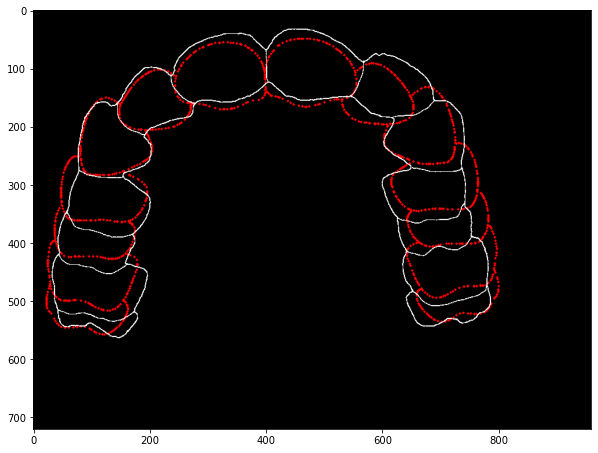

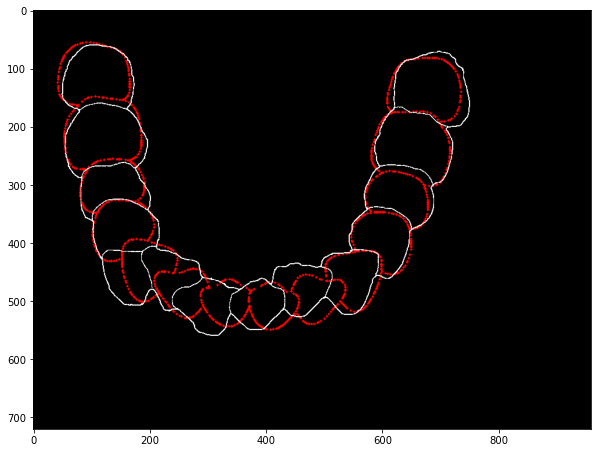

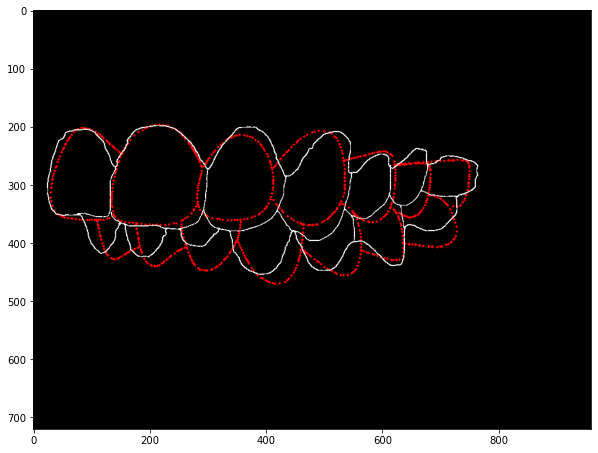

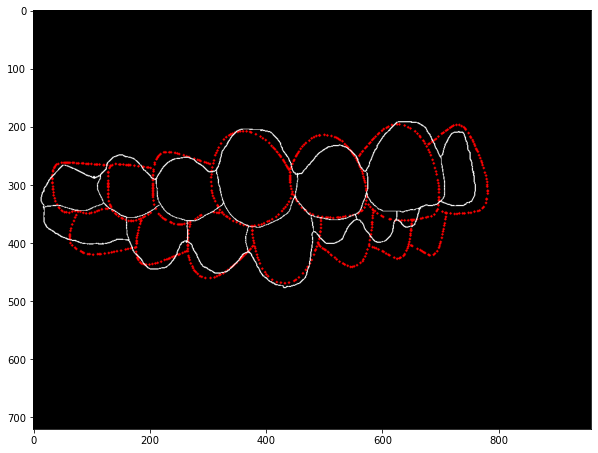

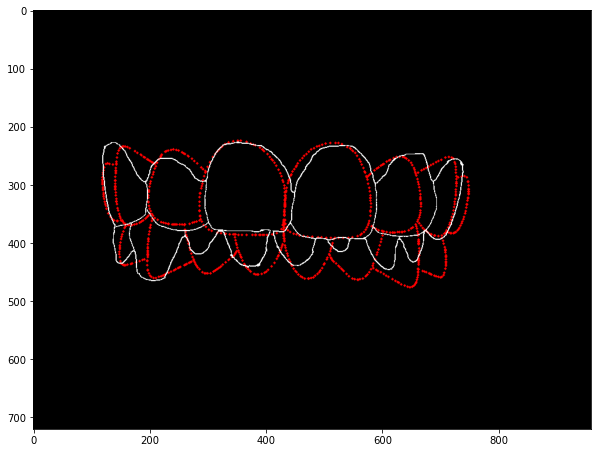

In [27]:
canvasShape = (720,960)
for photoType in photoTypes:
    emopt.showEdgeMaskPredictionWithGroundTruth(photoType, canvasShape, dilate=True)

In [ ]:
ExtrParamSearchSpace = {"rela_tx":np.array([-1.,0.,1.]), "rela_ty": np.array([-7,-6,-5,-4]), "rela_tz": np.array([-2,-1,0,1,2])} # tx:frontal, ty:left,right,frontal, tz:left,right,frontal

In [38]:
for it in range(30):
    emopt.maximization_stage1_step_5Views(rhobeg=1.0, maxiter=1000, verbose=True)
    print("M-step loss:", emopt.loss_maximization_step)
    emopt.expectation_step_5Views(verbose=True)
    print("iteration: {}, real Root Mean Squared Surface Distance(mm): {:.4f}".format(it, computeRMSE(emopt.X_trans, X_Ref)))

errorPixel: 387.02, errorAniScales: 0.01
errorPixel: 262.89, errorAniScales: 0.01
errorPixel: 518.29, errorAniScales: 0.01
errorPixel: 464.44, errorAniScales: 0.01
errorPixel: 635.78, errorAniScales: 0.01
maximization stage1 step errors: [1161.07,788.68,518.29,464.45,635.78]
M-step loss: 3568.27288458368
PHOTO.UPPER - unique pred points: 820 - E-step loss: 40.13
PHOTO.LOWER - unique pred points: 857 - E-step loss: 26.71
PHOTO.LEFT - unique pred points: 623 - E-step loss: 62.74
PHOTO.RIGHT - unique pred points: 575 - E-step loss: 47.08
PHOTO.FRONTAL - unique pred points: 620 - E-step loss: 54.52
iteration: 0, real Root Mean Squared Surface Distance(mm): 1.3686
errorPixel: 351.22, errorAniScales: 0.02
errorPixel: 199.66, errorAniScales: 0.02
errorPixel: 444.50, errorAniScales: 0.02
errorPixel: 449.35, errorAniScales: 0.02
errorPixel: 565.19, errorAniScales: 0.02
maximization stage1 step errors: [1053.71,599.03,444.52,449.37,565.21]
M-step loss: 3111.833305313803
PHOTO.UPPER - unique pred

KeyboardInterrupt: 

In [ ]:
# print(emopt.aniScales)
# print(emopt.aniScales.mean())
# print(np.prod(emopt.aniScales)**(1/3))

print("emopt.rela_txyz: ", emopt.rela_txyz)
print("emopt.rela_rxyz: ", emopt.rela_rxyz)
print("emopt.rowScaleXZ: ", emopt.rowScaleXZ)
print("approx tooth scale: ", np.prod(emopt.rowScaleXZ)**(1/3))

In [ ]:
# emopt.meanScales = np.prod(emopt.rowScaleXZ)**(1/3) * np.ones_like(emopt.scales, np.float32)
# emopt.meanTransVecXYZs[:,[0,2]] = emopt.X_Mu_centroids[:,[0,2]] * (emopt.rowScaleXZ - 1.)
# emopt.scales = np.prod(emopt.rowScaleXZ)**(1/3) * np.ones_like(emopt.scales, np.float32)
# emopt.transVecXYZs[:,[0,2]] = emopt.X_Mu_centroids[:,[0,2]] * (emopt.rowScaleXZ - 1.)
# emopt.rowScaleXZ = np.array([1.,1.], np.float32)
emopt.anistropicRowScale2ScalesAndTransVecs()
print("iteration: {}, real Root Mean Squared Surface Distance(mm): {:.4f}".format(it, computeRMSE(emopt.X_trans, X_Ref)))
print("transVecStd: {:.4f}, rotAngleStd: {:.4f}, scaleStd: {:.4f}".format(emopt.transVecStd, emopt.rotAngleStd, emopt.scaleStd))

In [ ]:
for it in range(10):
    emopt.maximization_stage2_step_5Views(rhobeg=0.1, maxiter=1000, step=2, verbose=True)
    emopt.maximization_stage2_step_5Views(rhobeg=0.1, maxiter=1000, step=3, verbose=False)
    emopt.maximization_stage2_step_5Views(rhobeg=0.1, maxiter=1000, step=1, verbose=False)
    emopt.expectation_step_5Views(verbose=True)
    print("M-step loss:", emopt.loss_maximization_step)
    print("iteration: {}, real Root Mean Squared Surface Distance(mm): {:.4f}".format(it, computeRMSE(emopt.X_trans, X_Ref)))

In [ ]:
canvasShape = (720,960)
for photoType in photoTypes:
    emopt.showEdgeMaskPredictionWithGroundTruth(photoType, canvasShape, dilate=True)

In [ ]:
# for it in range(5):
#     emopt.expectation_step_5Views(verbose=True)
#     emopt.maximization_stage3_step(verbose=True)
#     print("iteration: {}, real Root Mean Squared Surface Distance(mm): {:.4f}".format(it, computeRMSE(emopt.X_trans, X_Ref)))

In [ ]:
invRotAngleXYZVars = invRotAngleXYZVars.reshape(-1,3)
invTransVecXYZVars = invTransVecXYZVars.reshape(-1,3)
print("standard transVecXYZs:")
print((emopt.transVecXYZs - emopt.meanTransVecXYZs) / np.sqrt(invTransVecXYZVars[Mask]))
print("standard rotAngleXYZs:")
print((emopt.rotAngleXYZs - emopt.meanRotAngleXYZs) / np.sqrt(invRotAngleXYZVars[Mask]))
print("scales:")
print(emopt.scales)

In [ ]:
def showPredPointClouds(y,py):
    pcdY = o3d.geometry.PointCloud()
    pcdY.points = o3d.utility.Vector3dVector(y)
    pcdY.paint_uniform_color(np.array([1.,0.,0.]))
    pcdPY = o3d.geometry.PointCloud()
    pcdPY.points = o3d.utility.Vector3dVector(py)
    pcdPY.paint_uniform_color(np.array([0.,0.,1.]))
    o3d.visualization.draw_geometries([pcdY,pcdPY], window_name="Ground Truth PCL(red) and Prediction PCL(blue)", width=800, height=600, left=50,top=50, point_show_normal=False)

In [ ]:
# 均值牙列模型
# showPredPointClouds(y=X_Ref[:emopt.numUpperTooth].reshape(-1,3),py=emopt.X_Mu[:emopt.numUpperTooth].reshape(-1,3))
# showPredPointClouds(y=X_Ref[emopt.numUpperTooth:].reshape(-1,3),py=emopt.X_Mu[emopt.numUpperTooth:].reshape(-1,3))

In [ ]:
# 优化后对比
showPredPointClouds(y=X_Ref[:emopt.numUpperTooth].reshape(-1,3),py=(emopt.X_trans[:emopt.numUpperTooth]).reshape(-1,3))
showPredPointClouds(y=X_Ref[emopt.numUpperTooth:].reshape(-1,3),py=(emopt.X_trans[emopt.numUpperTooth:]).reshape(-1,3))

In [ ]:
withoutSecondMolarMask = np.tile(np.array([1,1,1,1,1,1,0],dtype=np.bool_),(4,))
print("iteration: {}, real Root Mean Squared Surface Distance(mm): {:.4f}".format(it, computeRMSE(emopt.X_trans[withoutSecondMolarMask[Mask]], X_Ref[withoutSecondMolarMask[Mask]])))

In [ ]:
emopt.rela_txyz = np.array([0.,-4.,-2.])
Xtrans = np.concatenate([emopt.X_trans[:emopt.numUpperTooth], np.matmul(emopt.X_trans[emopt.numUpperTooth:],emopt.rela_R)+emopt.rela_txyz], axis=0)
utils.showPointCloud(Xtrans.reshape(-1,3), "")

In [ ]:
print(emopt.rela_txyz)
print(emopt.rela_rxyz)

In [ ]:
def saveDemo2H5(h5File, emopt, patientId, X_Ref):
    if not os.path.exists(os.path.dirname(h5File)):
        os.makedirs(os.path.dirname(h5File))
    with h5py.File(h5File,'w') as f: #每次覆盖写入
        grp = f.create_group(str(patientId))
        grp.create_dataset("UPPER_INIT", data=np.array(emopt.X_Mu[:emopt.numUpperTooth], dtype=np.double))
        grp.create_dataset("LOWER_INIT", data=np.array(emopt.X_Mu[emopt.numUpperTooth:], dtype=np.double))
        grp.create_dataset("UPPER_PRED", data=np.array(emopt.X_trans[:emopt.numUpperTooth], dtype=np.double))
        grp.create_dataset("LOWER_PRED", data=np.array(emopt.X_trans[emopt.numUpperTooth:], dtype=np.double))
        grp.create_dataset("UPPER_REF", data=np.array(X_Ref[:emopt.numUpperTooth], dtype=np.double))
        grp.create_dataset("LOWER_REF", data=np.array(X_Ref[emopt.numUpperTooth:], dtype=np.double))
        grp.create_dataset("RELA_R", data=np.array(emopt.rela_R, dtype=np.double))
        grp.create_dataset("RELA_T", data=np.array(emopt.rela_txyz, dtype=np.double))
        
def readDemoFromH5(h5File, patientId):
    with h5py.File(h5File, 'r') as f:
        grp = f[str(patientId)]
        X_Mu_Upper = grp["UPPER_INIT"][:]
        X_Mu_Lower = grp["LOWER_INIT"][:]
        X_Pred_Upper = grp["UPPER_PRED"][:]
        X_Pred_Lower = grp["LOWER_PRED"][:]
        X_Ref_Upper = grp["UPPER_REF"][:]
        X_Ref_Lower = grp["LOWER_REF"][:]
        rela_R = grp["RELA_R"][:]
        rela_t = grp["RELA_T"][:]
    return X_Mu_Upper, X_Mu_Lower, X_Pred_Upper, X_Pred_Lower, X_Ref_Upper, X_Ref_Lower, rela_R, rela_t

In [ ]:
demoH5File = r"./dataWithPhoto/demo/demo_TagID={}.h5".format(TagID)
saveDemo2H5(demoH5File, emopt, TagID, X_Ref)

In [ ]:
patientID = TagID   
demoH5File2Load = r"./dataWithPhoto/demo/demo_TagID={}.h5".format(patientID)
X_Mu_Upper, X_Mu_Lower, X_Pred_Upper, X_Pred_Lower, X_Ref_Upper, X_Ref_Lower, rela_R, rela_t = readDemoFromH5(demoH5File2Load, patientID)

In [ ]:
# 牙列均值与Ground Truth对比
# showPredPointClouds(y=X_Ref_Upper.reshape(-1,3),py=X_Mu_Upper.reshape(-1,3))
# showPredPointClouds(y=X_Ref_Lower.reshape(-1,3),py=X_Mu_Lower.reshape(-1,3))
print("[RMSE] Root Mean Squared Surface Distance(mm): {:.4f}".format(computeRMSE(np.concatenate([X_Ref_Upper,X_Ref_Lower]), np.concatenate([X_Mu_Upper,X_Mu_Lower]))))
print("[ASSD] average symmetric surface distance (mm): {:.4f}".format(computeASSD(np.concatenate([X_Ref_Upper,X_Ref_Lower]), np.concatenate([X_Mu_Upper,X_Mu_Lower]))))
print("[HD] Hausdorff distance (mm): {:.4f}".format(computeHD(np.concatenate([X_Ref_Upper,X_Ref_Lower]), np.concatenate([X_Mu_Upper,X_Mu_Lower]))))

In [ ]:
# # 牙列预测与Ground Truth对比
# showPredPointClouds(y=X_Ref_Upper.reshape(-1,3),py=X_Pred_Upper.reshape(-1,3))
# showPredPointClouds(y=X_Ref_Lower.reshape(-1,3),py=X_Pred_Lower.reshape(-1,3))
print("[RMSE] Root Mean Squared Surface Distance(mm): {:.4f}".format(computeRMSE(np.concatenate([X_Ref_Upper,X_Ref_Lower]), np.concatenate([X_Pred_Upper,X_Pred_Lower]))))
print("[ASSD] average symmetric surface distance (mm): {:.4f}".format(computeASSD(np.concatenate([X_Ref_Upper,X_Ref_Lower]), np.concatenate([X_Pred_Upper,X_Pred_Lower]))))
print("[HD] Hausdorff distance (mm): {:.4f}".format(computeHD(np.concatenate([X_Ref_Upper,X_Ref_Lower]), np.concatenate([X_Pred_Upper,X_Pred_Lower]))))

In [ ]:
# 上下牙列咬合时的相对位置的预测
X_assem = np.concatenate([X_Pred_Upper, np.matmul(X_Pred_Lower, rela_R)+rela_t], axis=0)
utils.showPointCloud(X_assem.reshape(-1,3), "上下牙列咬合时的相对位置关系的预测")

### 验证忽略rowScale后的transVec是否正确

In [ ]:
sample = invParamDF[invParamDF["tag"]==TagID]
toothIndices = UPPER_INDICES+LOWER_INDICES
invScalesColumns = ["{}s".format(id) for id in toothIndices]
invRotAngleXYZColumns = ["{}r{}".format(id, p) for id in toothIndices for p in ["x","y","z"]]
invTransVecXYZColumns = ["{}t{}".format(id, p) for id in toothIndices for p in ["x","y","z"]]

In [ ]:
scales = sample[invScalesColumns].to_numpy().reshape((28,))
rotAngles = sample[invRotAngleXYZColumns].to_numpy().reshape((28,3))
transVecs = sample[invTransVecXYZColumns].to_numpy().reshape((28,3))
isp = 14
scales = scales[:isp][Mask[:isp]]
rotAngles = rotAngles[:isp][Mask[:isp]]
rotMats = np.array([utils.getRotMat(rxyz) for rxyz in rotAngles])
transVecs = transVecs[:isp][Mask[:isp]]
mu = Mu[:isp][Mask[:isp]]

In [ ]:
pg = scales[:,None,None] * np.matmul((mu-mu.mean(axis=1,keepdims=True)), rotMats) + transVecs[:,None,:] + mu.mean(axis=1,keepdims=True)

In [ ]:
ssaPath = "./data/ssa-repaired-txt/"
PGs = []
for tID in toothIndices:
    fp = os.path.join(ssaPath,str(tID),"{}U.txt".format(TagID))
    if os.path.exists(fp):
        x = np.loadtxt(fp)
        PGs.append(x)

In [ ]:
ref_pgs = np.vstack(PGs)
initTransVecShifts = invRegistrationParamDF[invRegistrationParamDF["tag"]==TagID]["upper_ts"].values[0]
pg = pg + initTransVecShifts[:,None,:]

In [ ]:
showPredPointClouds(y=ref_pgs,py=(pg).reshape(-1,3))